# Data Exploration Analysis and PID inventory level control

## The Dalinde Case: "Forecasting Patent Drugs Inventory "

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import os
import seaborn as sns; sns.set()

#### Loading Data

In [2]:
# Read CSVs
PatientConsumption = pd.read_csv('PatientConsumption 2018-2019.csv').drop_duplicates()
PurchasedOrders    = pd.read_csv('PurchasedOrders 2018-2019.csv').drop_duplicates()
IncompleteOrders   = pd.read_csv('IncompleteOrders 2018-2019.csv').drop_duplicates()
PatentDrugs        = pd.read_csv('Diccionario_v3.csv').drop_duplicates()

# Retrieve date columns and apply to_datetime, set amount columns as numeric
date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
PatientConsumption[date_columns]   = PatientConsumption[date_columns].apply(pd.to_datetime)
PatientConsumption[amount_columns] = PatientConsumption[amount_columns].astype(int)

date_columns = [column for column in PurchasedOrders.columns if 'Date' in column]
amount_columns = [column for column in PurchasedOrders.keys() if 'Amount' in column]
PurchasedOrders[date_columns]   = PurchasedOrders[date_columns].apply(pd.to_datetime)
PurchasedOrders[amount_columns] = PurchasedOrders[amount_columns].astype(int)

date_columns = [column for column in IncompleteOrders.columns if 'Date' in column]
amount_columns = [column for column in IncompleteOrders.keys() if 'Amount' in column]
IncompleteOrders[date_columns]   = IncompleteOrders[date_columns].apply(pd.to_datetime)
IncompleteOrders[amount_columns] = IncompleteOrders[amount_columns].astype(int)

_______________

#### Data Preparation

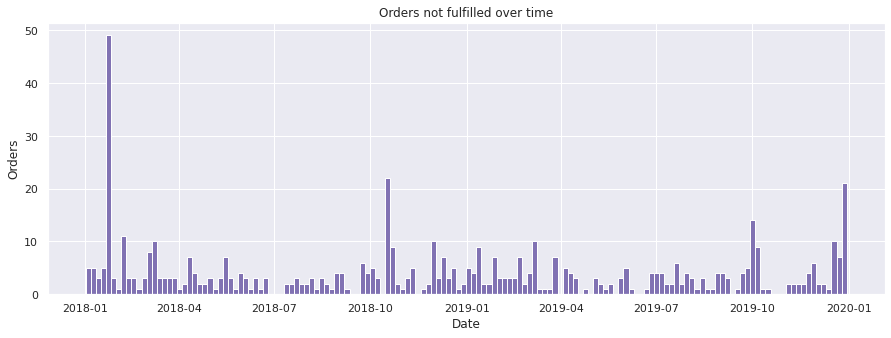

In [3]:
Shortages = PurchasedOrders[PurchasedOrders['AmountPurchased']==0]

plt.figure(figsize=(15, 5))
plt.hist(Shortages.RequestDate, bins = 150, facecolor='m')

plt.title('Orders not fulfilled over time')
plt.xlabel('Date')
plt.ylabel('Orders')

plt.grid(True)
plt.show()

# Part 1
Merge the dictionary with the PurchasedOrders database to keep only the **patent** drugs

In [4]:
PurchasedOrders.head()

,RequestNumber,RequestDate,PurchaseNumber,OrderDate,RequiredDeliveryDate,SupplierName,MedCode,MedDescription,Outflow,AmountRequested,AmountPurchased
0,52670,2018-01-02,257734.0,2018-01-02,2018-01-03,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,BOLENTAX (ENOXAPARINA) 40 MG/0.4 ML JER PRELL C/2,15.0,5,6
1,52670,2018-01-02,257734.0,2018-01-02,2018-01-03,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304883,BOLENTAX (ENOXAPARINA) 60 MG/0.6 ML JER PRELL C/2,14.0,2,2
2,52670,2018-01-02,257734.0,2018-01-02,2018-01-03,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304284,FRESUBIN PLUS VAINILLA 236 ML. FÓRMULA ENTERAL,15.0,5,5
3,52670,2018-01-02,257734.0,2018-01-02,2018-01-03,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3302098,NODESCRON 4MG AMPOLLETA (VECURONIO) PISA,39.0,40,50
4,52670,2018-01-02,257785.0,2018-01-02,2018-01-03,"NADRO, S.A.P.I. DE C.V.",3301771,SOMAZINA 1G AMP 4ML (CITICOLINA),424.0,10,10


In [5]:
PatentOrders = pd.merge(PurchasedOrders, PatentDrugs, on='MedCode').drop(columns='MedDescription_x').rename(columns={'MedDescription_y':'MedDescription'})
PatentOrders.head(7)

,RequestNumber,RequestDate,PurchaseNumber,OrderDate,RequiredDeliveryDate,SupplierName,MedCode,Outflow,AmountRequested,AmountPurchased,MedDescription,Compound,MedFamily,MedPriceMXN,MinStock,MaxStock
0,52670,2018-01-02,257734.0,2018-01-02,2018-01-03,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,15.0,5,6,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18
1,52734,2018-01-04,258004.0,2018-01-04,2018-01-05,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,19.0,2,2,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18
2,52882,2018-01-15,258670.0,2018-01-15,2018-01-16,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,16.0,2,2,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18
3,52950,2018-01-17,258882.0,2018-01-17,2018-01-18,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,13.0,2,2,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18
4,52980,2018-01-19,259057.0,2018-01-19,2018-01-22,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,21.0,5,6,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18
5,53200,2018-01-30,259808.0,2018-01-30,2018-01-31,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,15.0,4,4,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18
6,53227,2018-02-01,260010.0,2018-02-01,2018-02-02,DISTRIBUIDORA MEDICA CODIMED S.A. DE C.V.,3304784,12.0,3,4,BOLENTAX 40MG/0.4ML C/2 JGP (ENOXAPARINA SODICA),ENOXAPARINA SODICA,Sangre y órganos hematopoyéticos,694.0,7,18


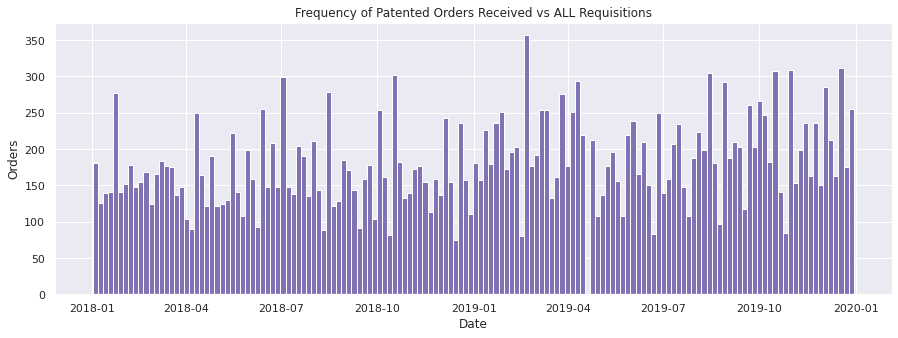

In [6]:
plt.figure(figsize=(15, 5))

plt.hist(PatentOrders.RequestDate, bins = 150, facecolor='m')

plt.title('Frequency of Patented Orders Received vs ALL Requisitions')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.grid(True)
plt.show()

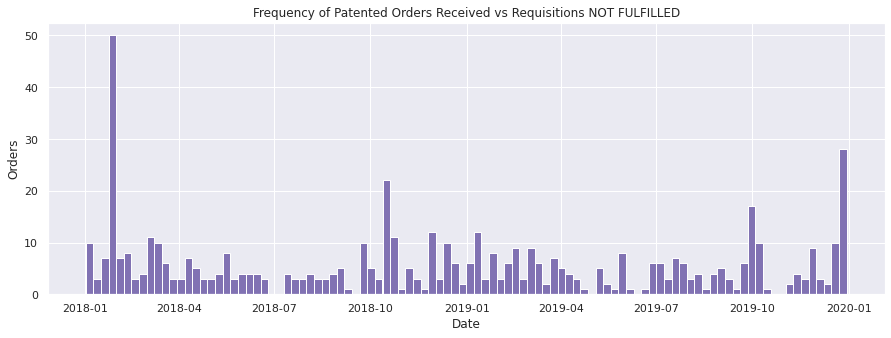

In [7]:
#NUMERO DE DESABASTOS
Shortages2 =PatentOrders[PatentOrders['AmountPurchased']==0]
plt.figure(figsize=(15, 5))
plt.hist(Shortages2.RequestDate, bins = 100, facecolor='m')
plt.title('Frequency of Patented Orders Received vs Requisitions NOT FULFILLED')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.grid(True)
plt.show()

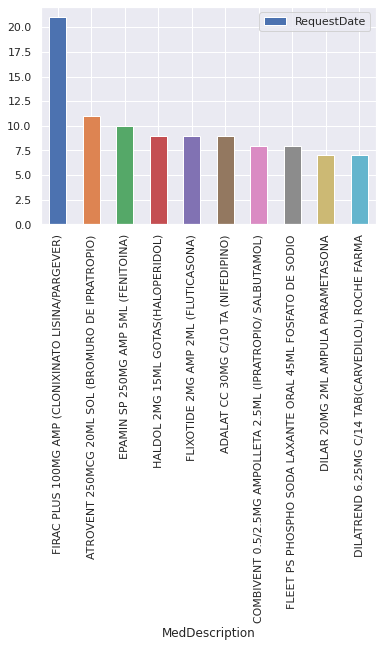

In [8]:
#Top 10 drugs with the most shortages
Shortages2.groupby('MedDescription').count().sort_values('RequestDate', ascending=False)[:10].reset_index().plot.bar(x='MedDescription', y='RequestDate');

In [9]:
#Top 10 Amount of drugs that had a shortage
Shortages2.groupby('MedDescription').sum().sort_values('AmountRequested', ascending=False).head(7)

,RequestNumber,PurchaseNumber,MedCode,Outflow,AmountRequested,AmountPurchased,MedPriceMXN,MinStock,MaxStock
MedDescription,,,,,,,,,
COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL),480424,0.0,26421352,6703.0,1200,0,4228.0,4728,12864
MEPROXIDINA 200MCG/2ML (DEXMEDETOMIDINA),385291,0.0,19830318,980.0,910,0,1194.0,1344,1344
FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGEVER),1258644,0.0,69348447,2775.0,543,0,3202.5,609,1764
CORPOTASIN CL C/50 TAB AMSTRONG,52984,0.0,3301594,413.0,413,0,433.0,2,6
FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),593804,0.0,29716002,61.0,140,0,6484.5,1062,2754
FALOT 1G AMP. PISA (CEFALOTINA),321705,0.0,16524065,50.0,130,0,845.0,500,920
AMPLIUM 1G AMP IV (MEROPENEM),106284,0.0,6609628,186.0,100,0,1328.0,32,96


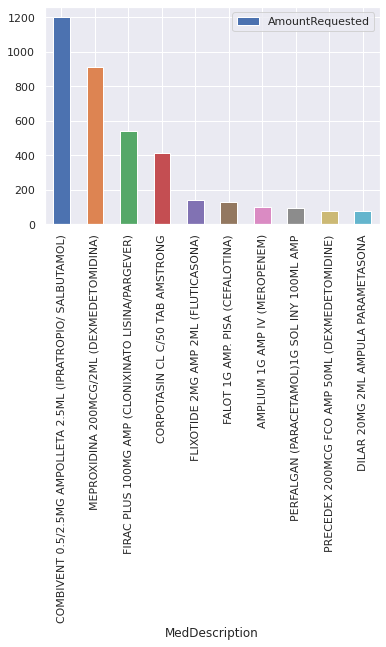

In [10]:
Shortages2.groupby('MedDescription').sum().sort_values('AmountRequested', ascending=False)[:10].reset_index().plot.bar(x='MedDescription', y='AmountRequested')

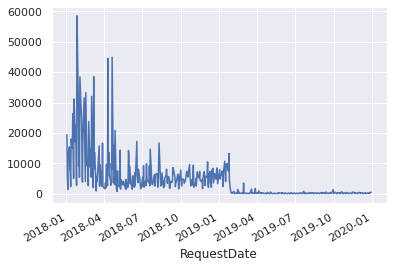

In [11]:
PatentOrders.groupby('RequestDate').sum()['Outflow'].plot()
#PREGUNTAR A JULIO

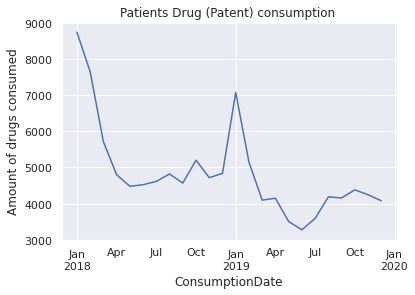

In [12]:
#CANTIDAD PEDIDA POR LOS PACIENTES
PatientConsumption.groupby('ConsumptionDate').sum()['AmountConsumed'].plot()
plt.ylabel("Amount of drugs consumed")
plt.title("Patients Drug (Patent) consumption ");

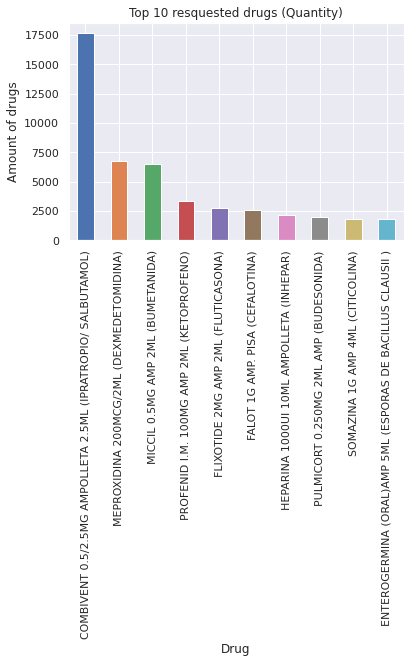

In [13]:
# Los que mas se compran
PatentOrders.groupby('MedDescription').sum().sort_values('AmountRequested', ascending=False)[:10]['AmountRequested'].plot.bar()
plt.title("Top 10 resquested drugs (Quantity)")
plt.ylabel("Amount of drugs")
plt.xlabel("Drug");

In [14]:
# Los que mas se demandan
top10_c= PatientConsumption.groupby('MedDescription').sum().sort_values('AmountConsumed',ascending=False)[:10].reset_index()
top10_c

,MedDescription,ConsumptionNumber,MedCode,AmountConsumed,UnitaryCost,TotalCost
0,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,8.135285e+10,4.812319e+10,16997,443372.20,517482.09
1,MICCIL 0.5MG AMP 2ML (BUMETANIDA),2.879226e+10,1.663857e+10,7235,79875.48,116150.01
2,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),1.566442e+10,9.169038e+09,2843,126029.59,129145.96
3,PULMICORT 0.250MG 2ML AMP (BUDESONIDA),1.245980e+10,7.805417e+09,2484,72048.02,75560.64
4,PROFENID IM (KETOPROFENO) 100MG/2ML AMP,1.339354e+10,7.507230e+09,2281,161678.22,162263.89
5,ENTEROGERMINA (ORAL)AMP 5ML (ESPORAS DE BACILL...,6.539944e+09,3.822669e+09,1949,15994.96,26997.81
6,SOMAZINA 1G AMP 4ML (CITICOLINA),1.027621e+10,5.929981e+09,1852,126801.89,130868.65
7,DICYNONE 250MG AMP 2ML (ETAMSILATO),7.821405e+09,4.528975e+09,1654,136554.01,165263.47
8,HEPARINA 1000UI 10ML AMPOLLETA (INHEPAR),7.741466e+09,4.487607e+09,1605,73787.49,86787.09
9,FOSFOCIL IV 1G AMP (FOSFOMICINA),8.170725e+09,4.718552e+09,1513,180634.15,191124.91


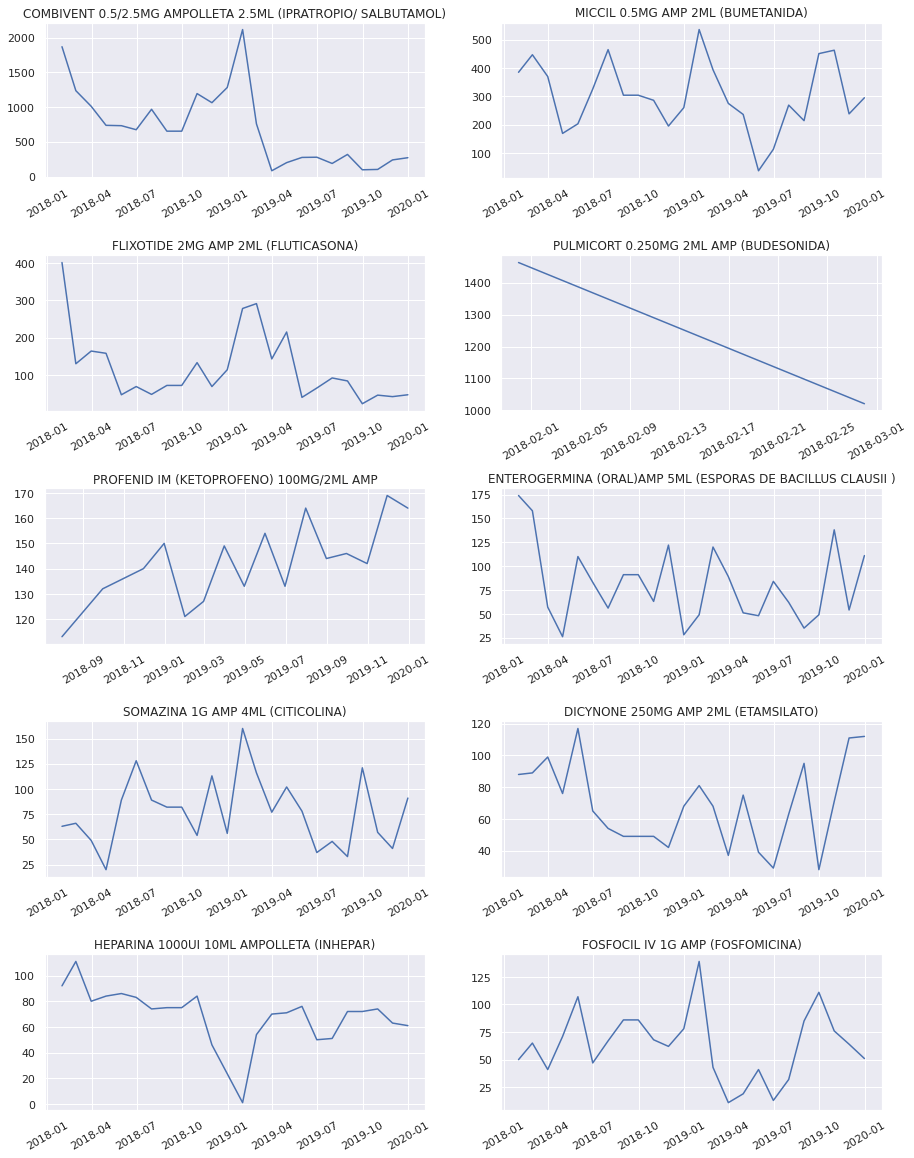

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(15,20))
fig.subplots_adjust(hspace=0.5)
for ax, med in zip(axes.flatten(), top10_c['MedDescription']):
    ax.plot(PatientConsumption[PatientConsumption['MedDescription']==med].groupby('ConsumptionDate').sum()['AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=med)

In [16]:
#GRAFICO DEL TIEMPO DE LOS MEDICAMENTOS VENDIDOS
#CALCULAR LA UTILIDAD DE LOS MEDICAMENTOS Y CUANTIFICARLA COMO COSTO DE OPORTUNIDAD DEL DESABASTO
#Proveedores a los que más se les compra

In [17]:
#VECES QUE FALTO COMO RAZÓN DEL TOTAL QUE SE PIDIÓ
veces_pedida=pd.DataFrame(PatentOrders.groupby('MedDescription').count()['RequestNumber']).sort_values('RequestNumber',ascending=False)[0:100].reset_index()
veces_faltante=pd.DataFrame(PatentOrders[PatentOrders['AmountPurchased']==0].groupby('MedDescription').count()['RequestDate']).reset_index()

veces_falto=pd.merge(veces_faltante,veces_pedida,on='MedDescription')
veces_falto['cociente']=veces_falto['RequestDate']/veces_falto['RequestNumber']
veces_falto.sort_values('cociente', ascending=False).reset_index(drop=True)[:15]

,MedDescription,RequestDate,RequestNumber,cociente
0,FLEET ENEMA AD LAB FOSF-SODIO 133ML SOL (FOSFA...,6,62,0.096774
1,ACTRON 400 400MG C/10 CAP (IBUPROFENO) LAB. BA...,7,73,0.095890
2,NIMOTOP 10MG AMP 50ML (NIMODIPINO),6,67,0.089552
3,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),9,144,0.062500
4,RENEGY 500MG/10ML AMP IV (CARBOXIMALTOSA FERRICA),5,81,0.061728
5,CUBICINE 500 MG AMP IV (DAPTOMICINA),5,87,0.057471
6,ATROVENT 250MCG 20ML SOL (BROMURO DE IPRATROPIO),11,242,0.045455
7,MEPROXIDINA 200MCG/2ML (DEXMEDETOMIDINA),6,134,0.044776
8,LIPITOR 80MG C/30 TAB(ATORVASTATINA),3,67,0.044776
9,HALOPERIL 5MG/ML AMP IM (HALOPERIDOL),4,97,0.041237


In [18]:
PatentOrders.groupby('MedFamily').count().sort_values('RequestDate', ascending=False)

,RequestNumber,RequestDate,PurchaseNumber,OrderDate,RequiredDeliveryDate,SupplierName,MedCode,Outflow,AmountRequested,AmountPurchased,MedDescription,Compound,MedPriceMXN,MinStock,MaxStock
MedFamily,,,,,,,,,,,,,,,
Tracto alimentario y metabolismo,6196,6196,6075,6075,6075,6075,6196,6196,6196,6196,6196,6196,6196,6196,6196
Sistema cardiovascular,3825,3825,3735,3735,3735,3735,3825,3825,3825,3825,3825,3825,3825,3825,3825
Sistema nervioso,3339,3339,3276,3276,3276,3276,3339,3339,3339,3339,3339,3339,3339,3339,3339
Antiinfecciosos para uso sistémico,2986,2986,2924,2924,2924,2924,2986,2986,2986,2986,2986,2986,2986,2986,2986
Sistema respiratorio,2732,2732,2666,2666,2666,2666,2732,2732,2732,2732,2732,2732,2732,2732,2732
Sistema musculoesquelético,2516,2516,2481,2481,2481,2481,2516,2516,2516,2516,2516,2516,2516,2516,2516
Sangre y órganos hematopoyéticos,2013,2013,1977,1977,1977,1977,2013,2013,2013,2013,2013,2013,2013,2013,2013
"Preparados hormonales sistémicos, excluyendo hormonas sexuales e insulinas",1039,1039,1010,1010,1010,1010,1039,1039,1039,1039,1039,1039,1039,1039,1039
Dermatológicos,787,787,774,774,774,774,787,787,787,787,787,787,787,787,787


In [19]:
top10_c= PatentOrders.groupby('MedFamily').sum().sort_values('AmountRequested',ascending=False)[:10].reset_index()
top10_c

,MedFamily,RequestNumber,PurchaseNumber,MedCode,Outflow,AmountRequested,AmountPurchased,MedPriceMXN,MinStock,MaxStock
0,Sistema respiratorio,163398766,7.678058e+08,9045917514,369019.00,27697,25671,1644392.00,162972,406600
1,Sistema nervioso,199433665,9.431371e+08,10833592544,307287.04,21309,19097,2192047.41,68571,116501
2,Tracto alimentario y metabolismo,371257261,1.754017e+09,20499065768,387272.50,17998,16714,3898769.00,52864,115975
3,Antiinfecciosos para uso sistémico,178725152,8.427331e+08,9889128304,181328.00,15180,13146,7702578.50,55952,128248
4,Sistema cardiovascular,227814253,1.072201e+09,12637584016,282629.00,13229,13210,2844682.40,44375,109315
5,Sistema musculoesquelético,149137950,7.089646e+08,8356733583,276472.00,13139,13114,1633471.30,46016,94176
6,Sangre y órganos hematopoyéticos,120521104,5.703357e+08,6695218991,95697.00,8773,8936,18384082.50,28008,66653
7,Varios,20957975,9.524975e+07,1163343969,18143.00,2814,2556,375599.50,11107,30646
8,"Preparados hormonales sistémicos, excluyendo h...",62253839,2.914281e+08,3442489771,47169.00,2670,2481,2031381.84,6199,14892
9,Dermatológicos,47077332,2.230111e+08,2609589657,44070.00,1212,1191,317000.47,2769,5499


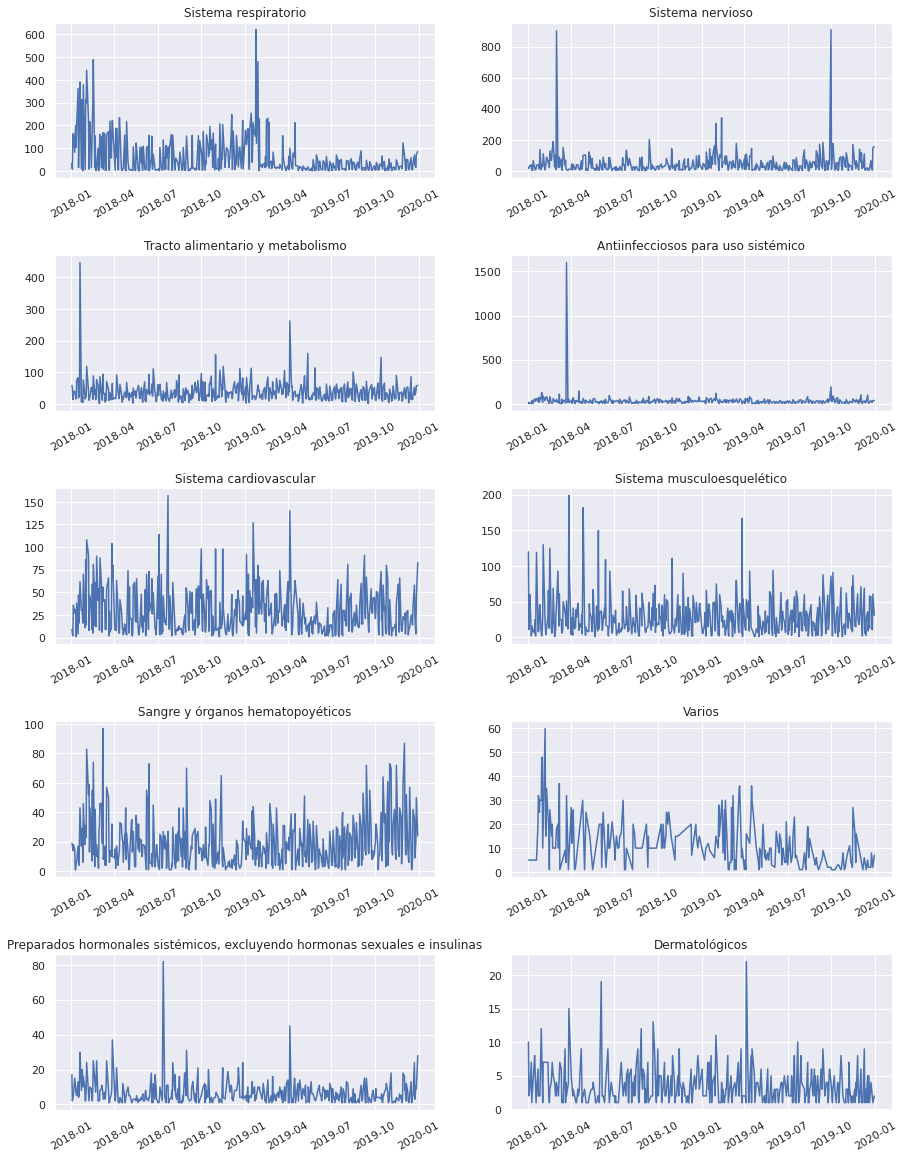

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(15,20))
fig.subplots_adjust(hspace=0.5)
for ax, med in zip(axes.flatten(), top10_c['MedFamily']):
    ax.plot(PatentOrders[PatentOrders['MedFamily']==med].groupby('RequestDate').sum()['AmountRequested'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=med)

_____________

### Part 2: Top 10 Diccionaries

In [21]:
#GRAFICO DEL TIEMPO DE LOS MEDICAMENTOS VENDIDOS
#Merge Orders and Consumption
#PatentOrders.head()
#PatientConsumption.head()

In [22]:
#Market Prices for each drug
PatientConsumption.groupby(["MedCode","UnitaryCost"]).count().head(10)

ConsumptionDate  Department  ConsumptionNumber  \
MedCode   UnitaryCost                                                   
1000255.0 73.28                      1           1                  1   
          83.50                      1           1                  1   
1000268.0 68.33                     11          11                 11   
          74.02                     98          98                 98   
          75.20                     29          29                 29   
          75.59                      3           3                  3   
          75.60                     30          30                 30   
          75.61                      6           6                  6   
          76.24                    123         123                123   
          76.64                     27          27                 27   

                       MedDescription  AmountConsumed  TotalCost  
MedCode   UnitaryCost                                             
1000255.0 73.28                     1               1          1  
          83.50                     1               1          1  
1000268.0 68.33                    11              11         11  
          74.02                    98              98         98  
          75.20                    29              29         29  
          75.59                     3               3          3  
          75.60                    30              30         30  
          75.61                     6               6          6  
          76.24                   123             123        123  
          76.64                    27              27         27

In [23]:
#Get the average market prices for each drug
DrugMktPrice=PatientConsumption.groupby("MedCode").mean()
DrugMktPrice.head(7)

,ConsumptionNumber,AmountConsumed,UnitaryCost,TotalCost
MedCode,,,,
1000255.0,5.702712e+06,1.000000,78.390000,85.070000
1000268.0,5.776963e+06,1.087108,78.086109,84.854228
1000280.0,5.576559e+06,1.044248,1173.143717,1243.456814
1000294.0,5.983552e+06,1.000000,783.250000,783.250000
2400207.0,5.487564e+06,1.000000,220.790000,220.790000
2900193.0,5.800344e+06,1.000000,504.829333,504.829333
2900217.0,5.682197e+06,1.000000,67.418750,67.418750


In [24]:
df=pd.merge(PatentOrders, DrugMktPrice, on="MedCode")

In [25]:
#Top 10 Missing
Top10Missing=df[df["AmountPurchased"]==0].groupby("MedDescription").count().sort_values("AmountRequested",ascending=False)[:10].index

In [26]:
#Top 10 Missing Quantity
Top10MissingQ=df[df["AmountPurchased"]==0].groupby("MedDescription").sum().sort_values("AmountRequested",ascending=False)[:10].index

In [27]:
#Top 10 Missing Relative to its Requests
veces_pedida=pd.DataFrame(PatentOrders.groupby('MedDescription').count()['RequestNumber']).sort_values('RequestNumber',ascending=False)[0:100].reset_index()
veces_faltante=pd.DataFrame(PatentOrders[PatentOrders['AmountPurchased']==0].groupby('MedDescription').count()['RequestDate']).reset_index()

veces_falto=pd.merge(veces_faltante,veces_pedida,on='MedDescription')
veces_falto['cociente']=veces_falto['RequestDate']/veces_falto['RequestNumber']
Top10MissingRelative=list(veces_falto.sort_values("cociente", ascending=False)[0:10].MedDescription)

In [28]:
top10_c= PatientConsumption.groupby('MedDescription').sum().sort_values('AmountConsumed',ascending=False)[:10].reset_index()
Top10Consummed=list(top10_c.MedDescription)
Top10Consummed
#CALCULAR LA UTILIDAD DE LOS MEDICAMENTOS Y CUANTIFICARLA COMO COSTO DE OPORTUNIDAD DEL DESABASTO
#Proveedores a los que más se les compra

['COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL)',
 'MICCIL 0.5MG AMP 2ML (BUMETANIDA)',
 'FLIXOTIDE 2MG AMP 2ML (FLUTICASONA)',
 'PULMICORT 0.250MG 2ML AMP (BUDESONIDA)',
 'PROFENID IM (KETOPROFENO) 100MG/2ML AMP',
 'ENTEROGERMINA (ORAL)AMP 5ML (ESPORAS DE BACILLUS CLAUSII )',
 'SOMAZINA 1G AMP 4ML (CITICOLINA)',
 'DICYNONE 250MG AMP 2ML (ETAMSILATO)',
 'HEPARINA 1000UI 10ML AMPOLLETA (INHEPAR)',
 'FOSFOCIL IV 1G AMP (FOSFOMICINA)']

### Part 3: Time series Analysis

### Harmonizing months

In [29]:
AmountCosummed=PatientConsumption.groupby(["ConsumptionDate","MedDescription"]).sum().reset_index()[["ConsumptionDate", "MedDescription", "AmountConsumed"]]
AmountCosummed.head()

,ConsumptionDate,MedDescription,AmountConsumed
0,2018-01-31,ACC 200MG C/20 TAB EFERV (ACETILCISTEINA),1
1,2018-01-31,ACC 600MG TAB EFERV (ACETILCISTEINA),2
2,2018-01-31,ACELER CO 2% CREMA 15G(ACIDO FUSIDICO/BETAMETA...,2
3,2018-01-31,ACETA DIAZOL 250MG C/30 TAB(ACETAZOLAMIDA),2
4,2018-01-31,ACTRON 200 200MG C/10 CAPS (IBUPROFENO),1


In [30]:
#End of month values
df["MonthRequest"]=pd.to_datetime(df['RequestDate'].map(lambda x: str(x.year) + "/" + str(x.month) + "/"+str(x.days_in_month)))
AmountRequested=df.groupby(["MonthRequest", "MedDescription"]).sum().reset_index()[["MonthRequest", "MedDescription", "AmountRequested"]]
AmountRequested.head(7)

,MonthRequest,MedDescription,AmountRequested
0,2018-01-31,ACANOL 2MG C/12 TAB (LOPERAMIDA) SANOFI,2
1,2018-01-31,ACC 600MG TAB EFERV (ACETILCISTEINA),1
2,2018-01-31,ACETA DIAZOL 250MG C/30 TAB(ACETAZOLAMIDA),2
3,2018-01-31,ACTRON 400 400MG C/10 CAP (IBUPROFENO) LAB. BA...,25
4,2018-01-31,ACTRON 600 600MG C/10 TAB (IBUPROFENO) BAYER,30
5,2018-01-31,ACTRON PLUS 400/100MG C/10 CAPS (IBUPROFENO+CA...,2
6,2018-01-31,ADALAT 10MG C/30 CAP(NIFEDIPINO),1


In [31]:
#Pendiente purchased
#df["MonthOrder"]=pd.to_datetime(df['OrderDate'].map(lambda x: str(x.year) + "/" + str(x.month)))
#AmountPurchased=df.groupby(["MonthOrder", "MedDescription"]).sum().reset_index()[["MonthOrder", "MedDescription", "AmountPurchased"]]

#### Top 10 Missing Time series

1. Requested orders (Peticiones de la farmacia)
2. Cosummed drugs (Consumido por pacientes)

### Top 10 Times missing 

In [32]:
master_missing=pd.merge(AmountCosummed[AmountCosummed["MedDescription"].isin(Top10Missing)], AmountRequested, left_on=["ConsumptionDate", "MedDescription"], right_on=["MonthRequest", "MedDescription"], how="left")
master_missing=master_missing.set_index("ConsumptionDate")

In [33]:
master_missing.head()

,MedDescription,AmountConsumed,MonthRequest,AmountRequested
ConsumptionDate,,,,
2018-01-31,ADALAT CC 30MG C/10 TA (NIFEDIPINO),3,2018-01-31,1.0
2018-01-31,ATROVENT 250MCG 20ML SOL (BROMURO DE IPRATROPIO),30,2018-01-31,27.0
2018-01-31,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,1869,2018-01-31,1800.0
2018-01-31,DILAR 20MG 2ML AMPULA PARAMETASONA,66,2018-01-31,61.0
2018-01-31,DILATREND 6.25MG C/14 TAB(CARVEDILOL) ROCHE FARMA,1,2018-01-31,4.0


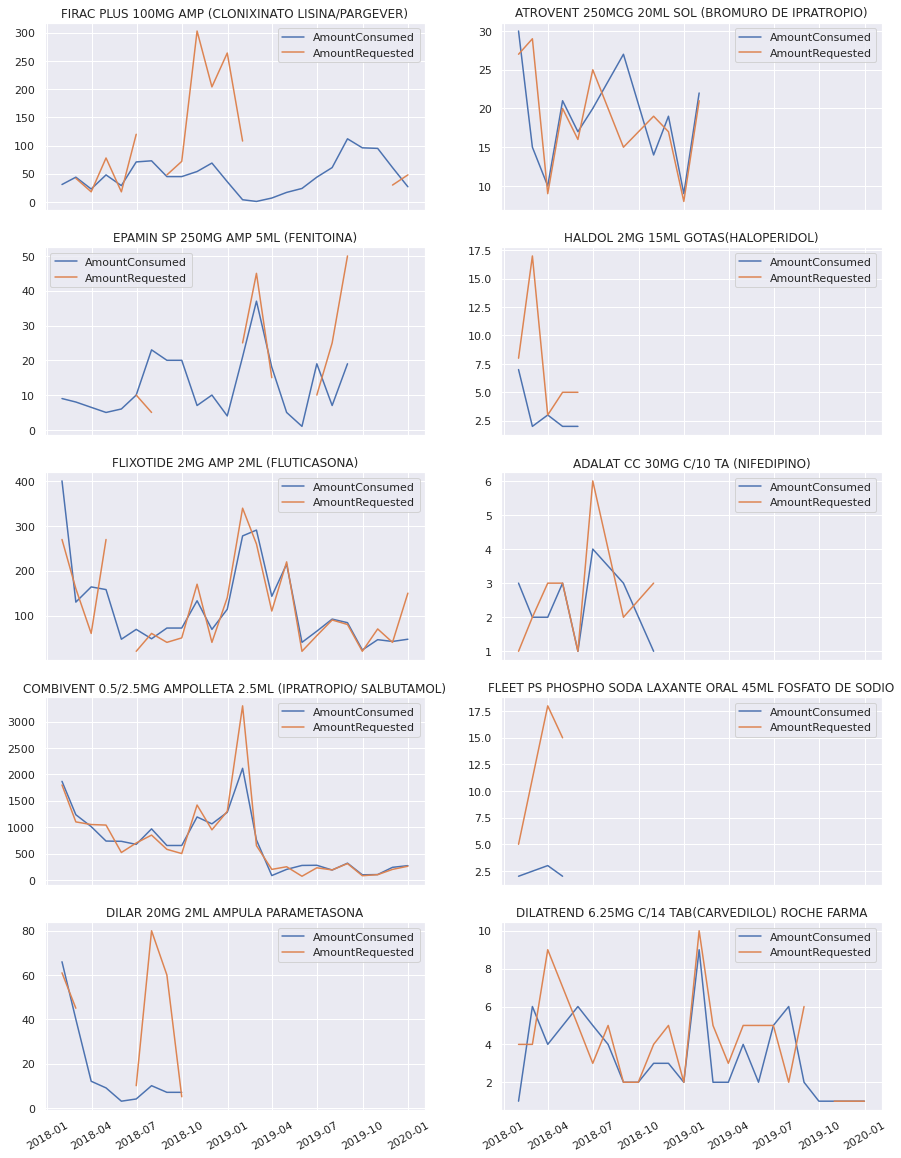

In [34]:
fig, axes = plt.subplots(5, 2, figsize=(15,20), sharex=True)
#fig.subplots_adjust(hspace=0.5)
for ax, med in zip(axes.flatten(), Top10Missing):
    ax.plot(master_missing[master_missing["MedDescription"]==med]["AmountConsumed"])
    ax.plot(master_missing[master_missing["MedDescription"]==med]["AmountRequested"])
    ax.legend(["AmountConsumed","AmountRequested"])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=med)

Some drugs do not have values for certain months, which suggests that analyzing the behaviour of the drugs grouped by medical compound is a better approach to reduce this phenomenon.

### Top 10 missing Drug Q

In [35]:
master_missing=pd.merge(AmountCosummed[AmountCosummed["MedDescription"].isin(Top10MissingQ)], AmountRequested, left_on=["ConsumptionDate", "MedDescription"], right_on=["MonthRequest", "MedDescription"], how="left")
master_missing=master_missing.set_index("ConsumptionDate")

In [36]:
master_missing.head()

,MedDescription,AmountConsumed,MonthRequest,AmountRequested
ConsumptionDate,,,,
2018-01-31,AMPLIUM 1G AMP IV (MEROPENEM),39,2018-01-31,100.0
2018-01-31,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,1869,2018-01-31,1800.0
2018-01-31,CORPOTASIN CL C/50 TAB AMSTRONG,4,2018-01-31,413.0
2018-01-31,DILAR 20MG 2ML AMPULA PARAMETASONA,66,2018-01-31,61.0
2018-01-31,FALOT 1G AMP. PISA (CEFALOTINA),168,2018-01-31,185.0


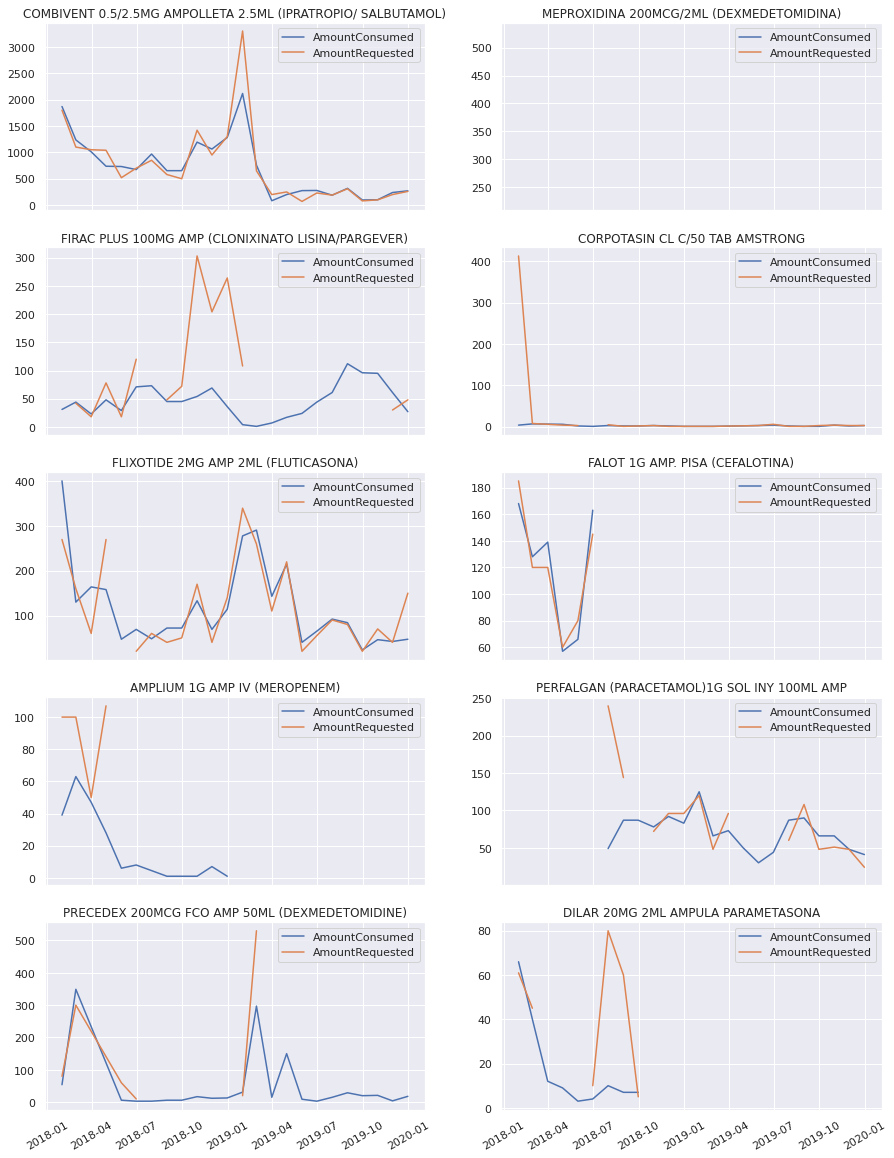

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(15,20), sharex=True)
#fig.subplots_adjust(hspace=0.5)
for ax, med in zip(axes.flatten(), Top10MissingQ):
    ax.plot(master_missing[master_missing["MedDescription"]==med]["AmountConsumed"])
    ax.plot(master_missing[master_missing["MedDescription"]==med]["AmountRequested"])
    ax.legend(["AmountConsumed","AmountRequested"])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=med)

In [38]:
#1. Agrupar por mes y medicamento el Amount Requested (cuando purchase ==0) 

### Top 10 missing relative

In [39]:
master_missing=pd.merge(AmountCosummed[AmountCosummed["MedDescription"].isin(Top10Consummed)], AmountRequested, left_on=["ConsumptionDate", "MedDescription"], right_on=["MonthRequest", "MedDescription"], how="left")
master_missing=master_missing.set_index("ConsumptionDate")

In [40]:
master_missing.head()

,MedDescription,AmountConsumed,MonthRequest,AmountRequested
ConsumptionDate,,,,
2018-01-31,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,1869,2018-01-31,1800.0
2018-01-31,DICYNONE 250MG AMP 2ML (ETAMSILATO),88,2018-01-31,84.0
2018-01-31,ENTEROGERMINA (ORAL)AMP 5ML (ESPORAS DE BACILL...,174,2018-01-31,160.0
2018-01-31,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),401,2018-01-31,270.0
2018-01-31,FOSFOCIL IV 1G AMP (FOSFOMICINA),50,2018-01-31,40.0


,MedDescription,AmountConsumed,MonthRequest,AmountRequested
ConsumptionDate,,,,


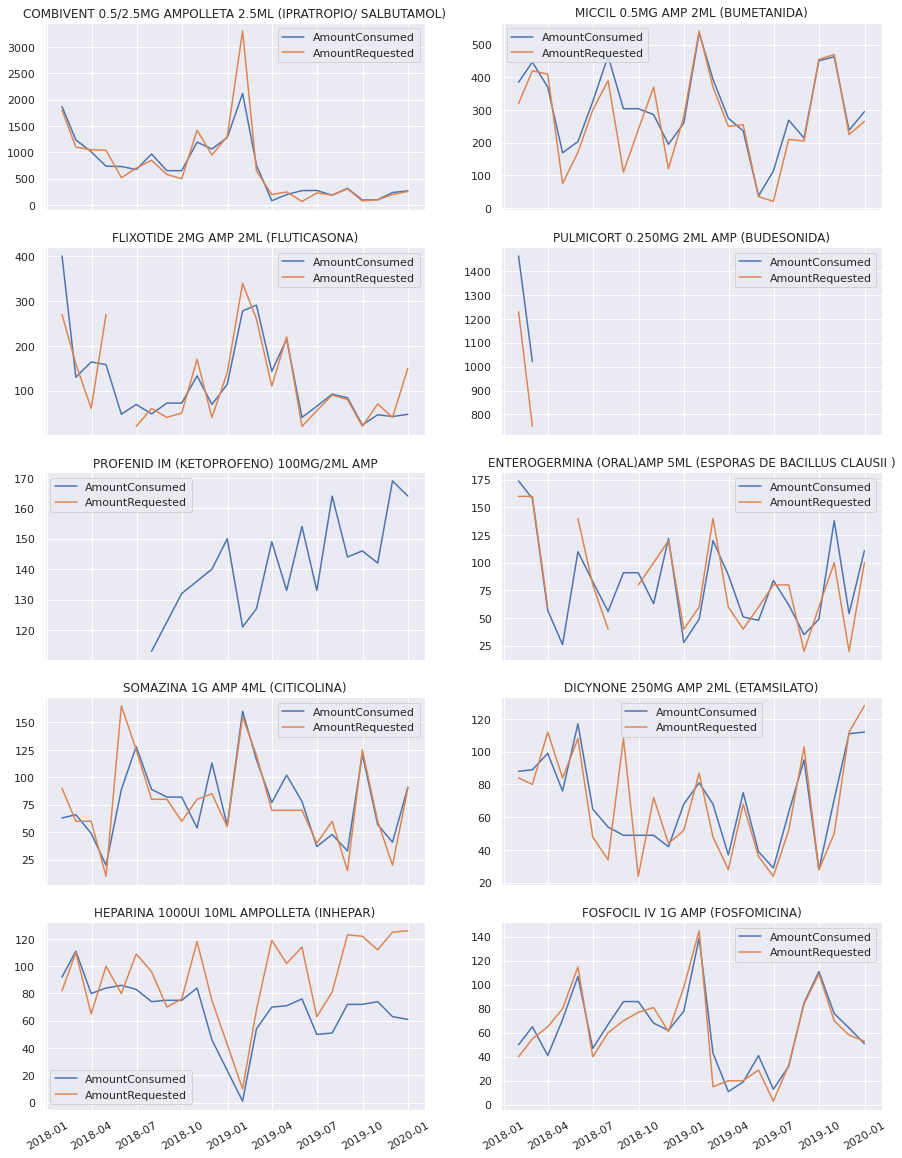

In [41]:
fig, axes = plt.subplots(5, 2, figsize=(15,20), sharex=True)
#fig.subplots_adjust(hspace=0.5)
for ax, med in zip(axes.flatten(), Top10Consummed):
    ax.plot(master_missing[master_missing["MedDescription"]==med]["AmountConsumed"])
    ax.plot(master_missing[master_missing["MedDescription"]==med]["AmountRequested"])
    ax.legend(["AmountConsumed","AmountRequested"])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=med)

master_missing[master_missing["MedDescription"]=="MEPROXIDINA 200MCG/2ML (DEXMEDETOMIDINA)"]

### Parte 4. Compound Analysis

#### Compounds Consumed 

In [42]:
ConsumedCompounds=pd.merge(PatientConsumption,PatentDrugs, on="MedCode").drop(columns="MedDescription_y").rename(columns={"MedDescription_x":"MedDescription"})

In [43]:
Top10Consumed=ConsumedCompounds.groupby("Compound").sum().sort_values("AmountConsumed",ascending=False)[0:10].index

#### 4.2 Check shortages

In [45]:
PurchasedCompounds=pd.merge(PurchasedOrders,PatentDrugs, on =["MedCode",'MedDescription']);
ShortagesCompounds=PurchasedCompounds[PurchasedCompounds["AmountPurchased"]==0].groupby("Compound").sum().sort_values("AmountRequested", ascending=False)[0:10]
ShortagesCompounds


,RequestNumber,PurchaseNumber,MedCode,Outflow,AmountRequested,AmountPurchased,MedPriceMXN,MinStock,MaxStock
Compound,,,,,,,,,
IPRATROPIO/ SALBUTAMOL,654626,0.0,36330154,7220.0,1205,0,6236.5,4740,12888
CLONIXINATO LISINA/PARGEVER,1258644,0.0,69348447,2775.0,543,0,3202.5,609,1764
CORPOTASIN,52984,0.0,3301594,413.0,413,0,433.0,2,6
FLUTICASONA,593804,0.0,29716002,61.0,140,0,6484.5,1062,2754
PARACETAMOL,54914,0.0,3305090,0.0,96,0,6035.5,54,101
GELATEIN,362976,0.0,19831245,13.0,82,0,2295.0,99,216
DEXMEDETOMIDINE,106906,0.0,6610000,868.0,80,0,1188.0,180,524
DILAR,400521,0.0,23106391,128.0,75,0,2639.0,133,350
FENITOINA,629843,0.0,33013640,31.0,70,0,9190.0,100,280


In [46]:
Top10Shortages=ShortagesCompounds.index
Top10Shortages

Index(['IPRATROPIO/ SALBUTAMOL', 'CLONIXINATO LISINA/PARGEVER', 'CORPOTASIN',
       'FLUTICASONA', 'PARACETAMOL', 'GELATEIN', 'DEXMEDETOMIDINE', 'DILAR',
       'FENITOINA', 'VANCOMICINA'],
      dtype='object', name='Compound')

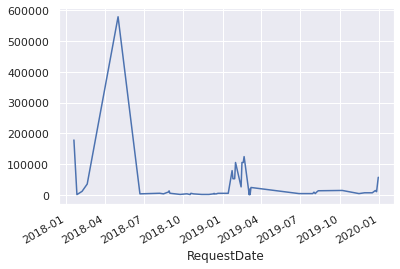

In [48]:
prices=PurchasedCompounds.loc[(PurchasedCompounds['Compound'].isin(Top10Shortages)) & (PurchasedCompounds['AmountPurchased']==0),:].groupby(["Compound", 'RequestDate']).sum().reset_index()
prices["Money"]=prices["AmountRequested"]*prices["MedPriceMXN"]
prices[prices["Money"]!=0].groupby("RequestDate").sum()["Money"].plot();

___

In [49]:
prices["Money"].sum()/20
series=PatentOrders[PatentOrders['Compound']=="IPRATROPIO/ SALBUTAMOL"][["RequestDate","AmountRequested"]]

1.	Just stay with those who report the 24 observations of the consumed drug base. (Emmanuel y Esteban)

In [50]:
TotalMonths=ConsumedCompounds.groupby(["ConsumptionDate", "Compound"]).count().reset_index().groupby("Compound").count().sort_values("ConsumptionDate", ascending=False)
CompleteMonthsCompounds=list(TotalMonths[TotalMonths["ConsumptionDate"]== 24].index)
df_24months= ConsumedCompounds[ConsumedCompounds["Compound"].isin(CompleteMonthsCompounds)]

2.	See the 10 most consumed. (Emmanuel y Esteban)

In [51]:
print(df_24months.groupby("Compound").sum().sort_values("TotalCost", ascending= False)[:15]["TotalCost"].sum(),"Total cost in MXN of the top 15 compounds")
top15=df_24months.groupby("Compound").sum().sort_values("TotalCost", ascending= False)[:15].index

6756197.839999975 Total cost in MXN of the top 15 compounds


In [52]:
print("The total cost of these top 15 compounds represents the", df_24months.groupby("Compound").sum().sort_values("TotalCost", ascending= False)[:15]["TotalCost"].sum()/df_24months["TotalCost"].sum()*100, "percent of the total cost for patent drugs that where consumed for all months during 2018-2019")
print("The total cost of these top 15 compounds represents the", df_24months.groupby("Compound").sum().sort_values("TotalCost", ascending= False)[:15]["TotalCost"].sum()/ConsumedCompounds["TotalCost"].sum()*100, "percent of the total cost for patent drugs during 2018-2019")

The total cost of these top 15 compounds represents the 52.950588760074524 percent of the total cost for patent drugs that where consumed for all months during 2018-2019
The total cost of these top 15 compounds represents the 19.540906662106917 percent of the total cost for patent drugs during 2018-2019


3.	Calculate the number of stockouts of those 15. (Emmanuel y Esteban)

In [53]:
Top15Shortages=PurchasedCompounds[PurchasedCompounds["Compound"].isin(top15)]
Top11=list(Top15Shortages[Top15Shortages["AmountPurchased"]==0].groupby("Compound").sum().sort_values("AmountRequested", ascending=False).index)

In [54]:
df_monetary11= ConsumedCompounds[ConsumedCompounds["Compound"].isin(Top11)]
print(df_monetary11.groupby("Compound").sum().sort_values("TotalCost", ascending= False)["TotalCost"].sum(),"Total cost in MXN of the top 11 compounds that have experienced at least 1 shortage")

print("The total cost of these top 11 compounds represents the", df_monetary11.groupby("Compound").sum().sort_values("TotalCost", ascending= False)["TotalCost"].sum()/df_24months["TotalCost"].sum()*100, "percent of the total cost for patent drugs that where consumed for all months during 2018-2019")
print("The total cost of these top 11 compounds represents the", df_monetary11.groupby("Compound").sum().sort_values("TotalCost", ascending= False)["TotalCost"].sum()/ConsumedCompounds["TotalCost"].sum()*100, "percent of the total cost for patent drugs during 2018-2019")

3290253.5399999768 Total cost in MXN of the top 11 compounds that have experienced at least 1 shortage
The total cost of these top 11 compounds represents the 25.786820670266046 percent of the total cost for patent drugs that where consumed for all months during 2018-2019
The total cost of these top 11 compounds represents the 9.51637871513346 percent of the total cost for patent drugs during 2018-2019


4.	Compare the requisitions of those 11. (Emmanuel y Esteban)

In [55]:
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound','MedPriceMXN']], on='MedCode', how='left')
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound','MedPriceMXN']], on='MedCode', how='left')

MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Requested, Purchased
AmountOrder = MedOrders.groupby(['YearMonth','Compound']).sum()[['AmountRequested','AmountPurchased']].reset_index()
# Consumed
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','Compound']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
# Missing
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
AmountMissing = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
AmountMissing['AmountMissing'] = AmountMissing['AmountRequested'] - AmountMissing['AmountPurchased']
AmountMissing = pd.merge(AmountMissing, PatentDrugs, on='MedCode').groupby(['YearMonth','Compound']).sum()['AmountMissing'].reset_index()

<h1><center>MedCode Analysis<br> To get the top 9</center></h1>

1. Only stay with those who report the 24 observations of the consumed drug base. (Emmanuel y Esteban)

In [61]:
TotalMonths=ConsumedCompounds.groupby(["ConsumptionDate", "MedDescription"]).count().reset_index().groupby("MedDescription").count().sort_values("ConsumptionDate", ascending=False)
CompleteMonthsMedCodes=list(TotalMonths[TotalMonths["ConsumptionDate"]== 24].index)
df_24months= ConsumedCompounds[ConsumedCompounds["MedDescription"].isin(CompleteMonthsMedCodes)]

2.	The 20 more consumed. (Emmanuel y Esteban)

In [62]:
print(df_24months.groupby(["MedCode","MedDescription"]).sum().sort_values("TotalCost", ascending= False)[0:20]["TotalCost"].sum(),"Total cost in MXN of the top 20 MedCodes")
top20 = df_24months.groupby(["MedDescription"]).sum().sort_values("TotalCost", ascending= False).index[:20]

3726996.6799999787 Total cost in MXN of the top 20 MedCodes


In [63]:
print("The total cost of these top 20 MedCodes represents the", df_24months.groupby("MedDescription").sum().sort_values("TotalCost", ascending= False).head(20)["TotalCost"].sum()/df_24months["TotalCost"].sum()*100, "percent of the total cost for patent drugs that where consumed for all months during 2018-2019")
print("The total cost of these top 20 MedCodes represents the", df_24months.groupby("MedDescription").sum().sort_values("TotalCost", ascending= False).head(20)["TotalCost"].sum()/ConsumedCompounds["TotalCost"].sum()*100, "percent of the total cost for patent drugs during 2018-2019")

The total cost of these top 20 MedCodes represents the 83.63789935825278 percent of the total cost for patent drugs that where consumed for all months during 2018-2019
The total cost of these top 20 MedCodes represents the 10.779568031989752 percent of the total cost for patent drugs during 2018-2019


3.	Calculate the number of stockouts of those 15. (Emmanuel y Esteban)

In [64]:
Top20Shortages=PurchasedCompounds[PurchasedCompounds["MedDescription"].isin(top20)]
TopS=list(Top20Shortages[Top20Shortages["AmountPurchased"]==0].groupby("MedDescription").sum().sort_values("AmountRequested", ascending=False).index)
TopS

['COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL)',
 'FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGEVER)',
 'FLIXOTIDE 2MG AMP 2ML (FLUTICASONA)',
 'SOMAZINA 1G AMP 4ML (CITICOLINA)',
 'INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)',
 'MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL',
 'VANCOCIN CP 1G AMP (VANCOMICINA)',
 'COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATRO./ SALBUTAMOL',
 'LIPITOR 80MG C/30 TAB(ATORVASTATINA)']

In [65]:
df_monetary10= ConsumedCompounds[ConsumedCompounds["MedDescription"].isin(TopS)]
print(df_monetary10.groupby("MedDescription").sum().sort_values("TotalCost", ascending= False)["TotalCost"].sum(),"Total cost in MXN of the top 11 MedCodes that have experienced at least 1 shortage")

print("The total cost of these top 10 MedCodes represents the", df_monetary10.groupby("MedDescription").sum().sort_values("TotalCost", ascending= False)["TotalCost"].sum()/df_24months["TotalCost"].sum()*100, "percent of the total cost for patent drugs that where consumed for all months during 2018-2019")
print("The total cost of these top 10 MedCodes represents the", df_monetary10.groupby("MedDescription").sum().sort_values("TotalCost", ascending= False)["TotalCost"].sum()/ConsumedCompounds["TotalCost"].sum()*100, "percent of the total cost for patent drugs during 2018-2019")

1794651.7999999756 Total cost in MXN of the top 11 MedCodes that have experienced at least 1 shortage
The total cost of these top 10 MedCodes represents the 40.27395769816088 percent of the total cost for patent drugs that where consumed for all months during 2018-2019
The total cost of these top 10 MedCodes represents the 5.190659620290489 percent of the total cost for patent drugs during 2018-2019


4. Compare the requisitions of those 10. (Emmanuel y Esteban)

___

In [66]:
# Consumed
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
# Requested, Purchased
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Incomplete
MedIncompleteOrders = pd.merge(IncompleteOrders[IncompleteOrders['RequestNumber']!=0], PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedIncompleteOrders['YearMonth'] = pd.to_datetime(MedIncompleteOrders['RequestDate'].dt.year*100+MedIncompleteOrders['RequestDate'].dt.month, format='%Y%m')

Compute `AmountRequested`, `AmountPurchased`, `AmountReceived` and `AmountMissing` per `[Month,RequestNumber,MedCode]`.

In [67]:
# 26763 requests
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
# 26763 purchases
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
# 1013 incomplete
AmountReceived = MedIncompleteOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountReceived'].reset_index()

# Merge columns to a total of 26763 rows
df = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
df = pd.merge(df, AmountReceived, on=['YearMonth','RequestNumber','MedCode'], how='left')
# if AmountReceived.isna() : order is complete
df['AmountReceived'] = df.apply(lambda x: x['AmountPurchased'] if pd.isna(x['AmountReceived']) else x['AmountReceived'], axis=1)
# compute shortage amount
df['AmountMissing'] = df['AmountRequested'] - df['AmountReceived']

df[(df['AmountPurchased']!=df['AmountReceived']) & (df['AmountRequested']!=df['AmountPurchased'])].head()

,YearMonth,RequestNumber,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
438,2018-01-01,52936,3300586,1,2,0.0,1.0
677,2018-01-01,53062,3300627,10,19,1.0,9.0
717,2018-01-01,53076,3300952,15,30,0.0,15.0
1975,2018-03-01,53801,3305045,20,270,0.0,20.0
2069,2018-03-01,53877,3300072,18,20,0.0,18.0


In [68]:
AmountOrder = df.groupby(['YearMonth','MedCode']).sum().reset_index()
AmountOrder.head(5)

,YearMonth,MedCode,RequestNumber,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
0,2018-01-01,1000268,53070,15,18,18.0,-3.0
1,2018-01-01,2900193,52984,2,2,2.0,0.0
2,2018-01-01,2900517,318161,7,6,5.0,2.0
3,2018-01-01,3300018,52984,2,2,0.0,2.0
4,2018-01-01,3300029,53140,1,1,1.0,0.0


Compute `AmountConsumed` per `[Month,Compound]`.

In [69]:
# Consumed
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedCode','AmountConsumed']]
AmountConsumed.head()

,YearMonth,MedCode,AmountConsumed
0,2018-01-01,1000268.0,22
1,2018-01-01,2900193.0,2
2,2018-01-01,2900517.0,3
3,2018-01-01,3300018.0,1
4,2018-01-01,3300029.0,1


Compute `AmountRequested`, `AmountPurchased`, `AmountReceived` and `AmountMissing` per `[Month,Compound]`.

Merge all amounts on `[Month,MedCode]`.

<h1><center> PID INVENTORY  LEVEL CONTROL </center><h1>

## (PID) Proportional Integral and Diferential model

------------------

The levels of inventory is a parameter that brings up 3 immediate challenges:
1. If the inventory stock level is high, we have maintenance costs to attend, like: storage rent, staff for managing it, utilities (electricity), etc.
2. A high level of inventory represents a large investment that is not being recovered.
3. A low level of inventory represents scarcity or shortage, which could translate to loss of money when bringing care to patients.

Therefore, we see that an optimal inventory level could exist at minimal costs. To find this optimal level, we will  use control technique model name PID, which stands for Proportional, Integral, and Diferential.

------------------

***Inventory Management***
To properly manage an inventory, the following policies are required:
1. Buy a defined amount (Q) when:<br>
	AIL, Actual Inventory Level  < OL, Optimum Level (of Required Inventory)
2. Buy the difference between OL - AIL  when:<br>
	AIL, Actual Inventory Level  < OL, Optimum Level (of Required Inventory)
3. If a defined time period passes, no matter what the inventory level is, one buys only when: <br>OL – AIL is positive.

With the given data, we are able to estimate the current inventory levels. This estimation **cannot** be reviewed with the Outflows column in the purchase orders report because when substracting Consumed – Received, some results are negative and they shed light on **unregistered shortages**  

In [70]:
MonthlyCompounds = pd.merge(AmountOrder, AmountConsumed, on=['YearMonth','MedCode'], how='outer')
# fill AmountConsumed.isna() with zeros
#MonthlyCompounds['AmountConsumed'] = MonthlyCompounds['AmountConsumed'].fillna(0)
MonthlyCompounds = MonthlyCompounds.fillna(0)
MonthlyCompounds['AmountInventory'] = MonthlyCompounds['AmountReceived'] - MonthlyCompounds['AmountConsumed']
MonthlyCompounds['date_ordinal'] = pd.to_datetime(MonthlyCompounds['YearMonth']).apply(lambda date: date.toordinal())


#Aquí estoy haciendo la modificación
MonthlyCompounds.head()

,YearMonth,MedCode,RequestNumber,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed,AmountInventory,date_ordinal
0,2018-01-01,1000268,53070.0,15.0,18.0,18.0,-3.0,22.0,-4.0,736695
1,2018-01-01,2900193,52984.0,2.0,2.0,2.0,0.0,2.0,0.0,736695
2,2018-01-01,2900517,318161.0,7.0,6.0,5.0,2.0,3.0,2.0,736695
3,2018-01-01,3300018,52984.0,2.0,2.0,0.0,2.0,1.0,-1.0,736695
4,2018-01-01,3300029,53140.0,1.0,1.0,1.0,0.0,1.0,0.0,736695


In [71]:
MonthlyCompounds = pd.merge(MonthlyCompounds, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')
MonthlyCompounds.head(5)

,YearMonth,MedCode,RequestNumber,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed,AmountInventory,date_ordinal,MedDescription
0,2018-01-01,1000268,53070.0,15.0,18.0,18.0,-3.0,22.0,-4.0,736695,HALOPERIL 5MG/ML AMP IM (HALOPERIDOL)
1,2018-01-01,2900193,52984.0,2.0,2.0,2.0,0.0,2.0,0.0,736695,REFRESH TEARS GTS 15ML (CARBOXIMETILCELULOSA S...
2,2018-01-01,2900517,318161.0,7.0,6.0,5.0,2.0,3.0,2.0,736695,ALBUMINA DE HUEVO 400GR OVOPROT
3,2018-01-01,3300018,52984.0,2.0,2.0,0.0,2.0,1.0,-1.0,736695,LYRICA 150MG C/14 TAB(PREGABALINA)
4,2018-01-01,3300029,53140.0,1.0,1.0,1.0,0.0,1.0,0.0,736695,ADIMOD SOLUCION 800MG/7ML CAJA C/10 FCO (PIDOT...


Plot time series

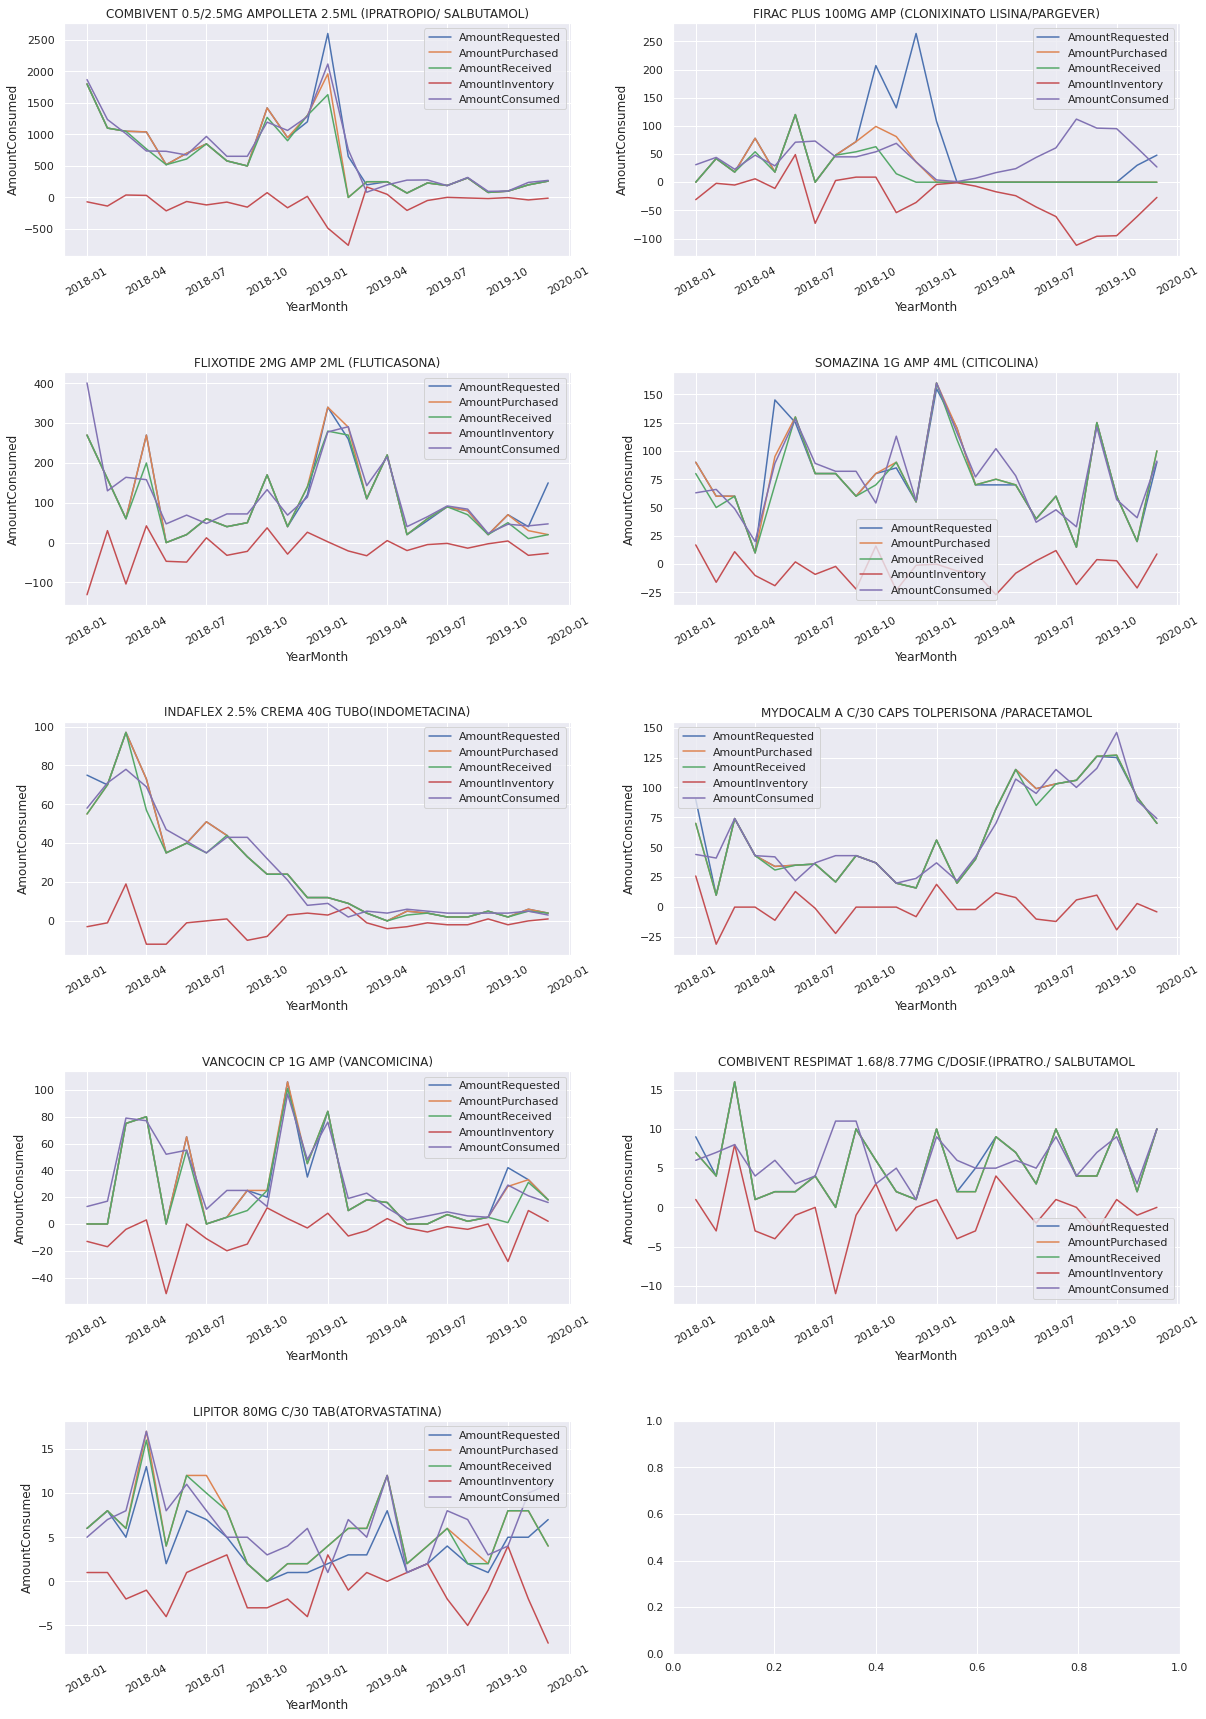

In [72]:
# Plot top compounds and inventory

fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
MonthlyCompounds.to_csv('monthCompound.csv')
for ax, MedCode in zip(axes.flatten(), TopS):
    
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountRequested', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountPurchased', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountReceived', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountInventory', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)

    ax.legend(["AmountRequested","AmountPurchased",'AmountReceived','AmountInventory','AmountConsumed'])
    #ax.legend(["AmountRequested","AmountPurchased",'AmountMissing','AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)
    
plt.savefig('PID CSV/top9.jpg')

-------------------
We can conclude from previous graphs that these 9 medicines

***COMBIVENT 0.5/2.5 MG:*** This patent medicine had a negative stock level, and with important variations up until June, 2019. After this month, the inventory stock level is maintained close to ZERO, and the comparative variables show a constant behavior.

***FIRAC PLUS 100MG:*** After February 2019, there is not enough data to be able to calculate the inventory stock level, however, previous data shows that it kept below ZERO, which means in shortage. In previous months, it shows two very strong shortages. 

***FLIXOTIDE 2MG:*** Around April, 2019, one can observe the inventory level being stable, however, it is still very close to ZERO or under ZERO, which indicates shortage. 


***SOMAZINA 1GR:*** The inventory stock level keeps oscillating under zero, and very few times overcomes it, which on average you can see shortages. Some other observed characteristics is its stability through time. This inventory stock oscillates with measurable periods.  Regardless of the period, we can conclude from the graph that ***the procurement department is following a procurement model proportional with the shortage, that is, the inventory stock is maintained at ZERO because it is purchased only when it is needed, therefore, there is not an attempt to stay above zero.***

***INDAFLEX 2.5%:*** Same case as for COMBIVENT, it shows a lot of stability after April, 2019, and an inventory level below zero. 

***MYDOCALM A C/30:*** We can reach the same conclusion as for SOMAZINA 1GR.


**VANCOCIN CP IMG:** On this chart, we can observe again how in April, 2019, there was an stability between the inventory levels, and its associated variables. However, in October, 2019, there was a sudden increase in demand, and you can immediately notice a shortage. Also, we observe the levels of inventory that keep oscillating below zero.

**COMBIVENT RESPIMAT:** This is a case, again, of a clear oscillating behavior proportional with the demand, the inventory level has almost always shortages on average. 


**LIPITOR 80MG:** Very similar with the previous medicine COMBIVENT RESPIMAT, we observe an inventory level that oscillates proportionally along with the demand, and has shortages almost always on average. 



**To further review the average inventory stock levels, we perform a linear regression of the levels of inventory.**

Intercept: -49833.69021699631 slope: [0.06748984]
Intercept: 79312.93447833924 slope: [-0.10764822]
Intercept: -34220.79023654495 slope: [0.04640643]
Intercept: 827.2692927022047 slope: [-0.00112875]
Intercept: -1198.6413256304122 slope: [0.00162498]
Intercept: -308.60167162902115 slope: [0.00041729]
Intercept: -14006.42288354517 slope: [0.01899509]
Intercept: -633.9219471522248 slope: [0.00085901]
Intercept: 1621.5597559050084 slope: [-0.0022011]


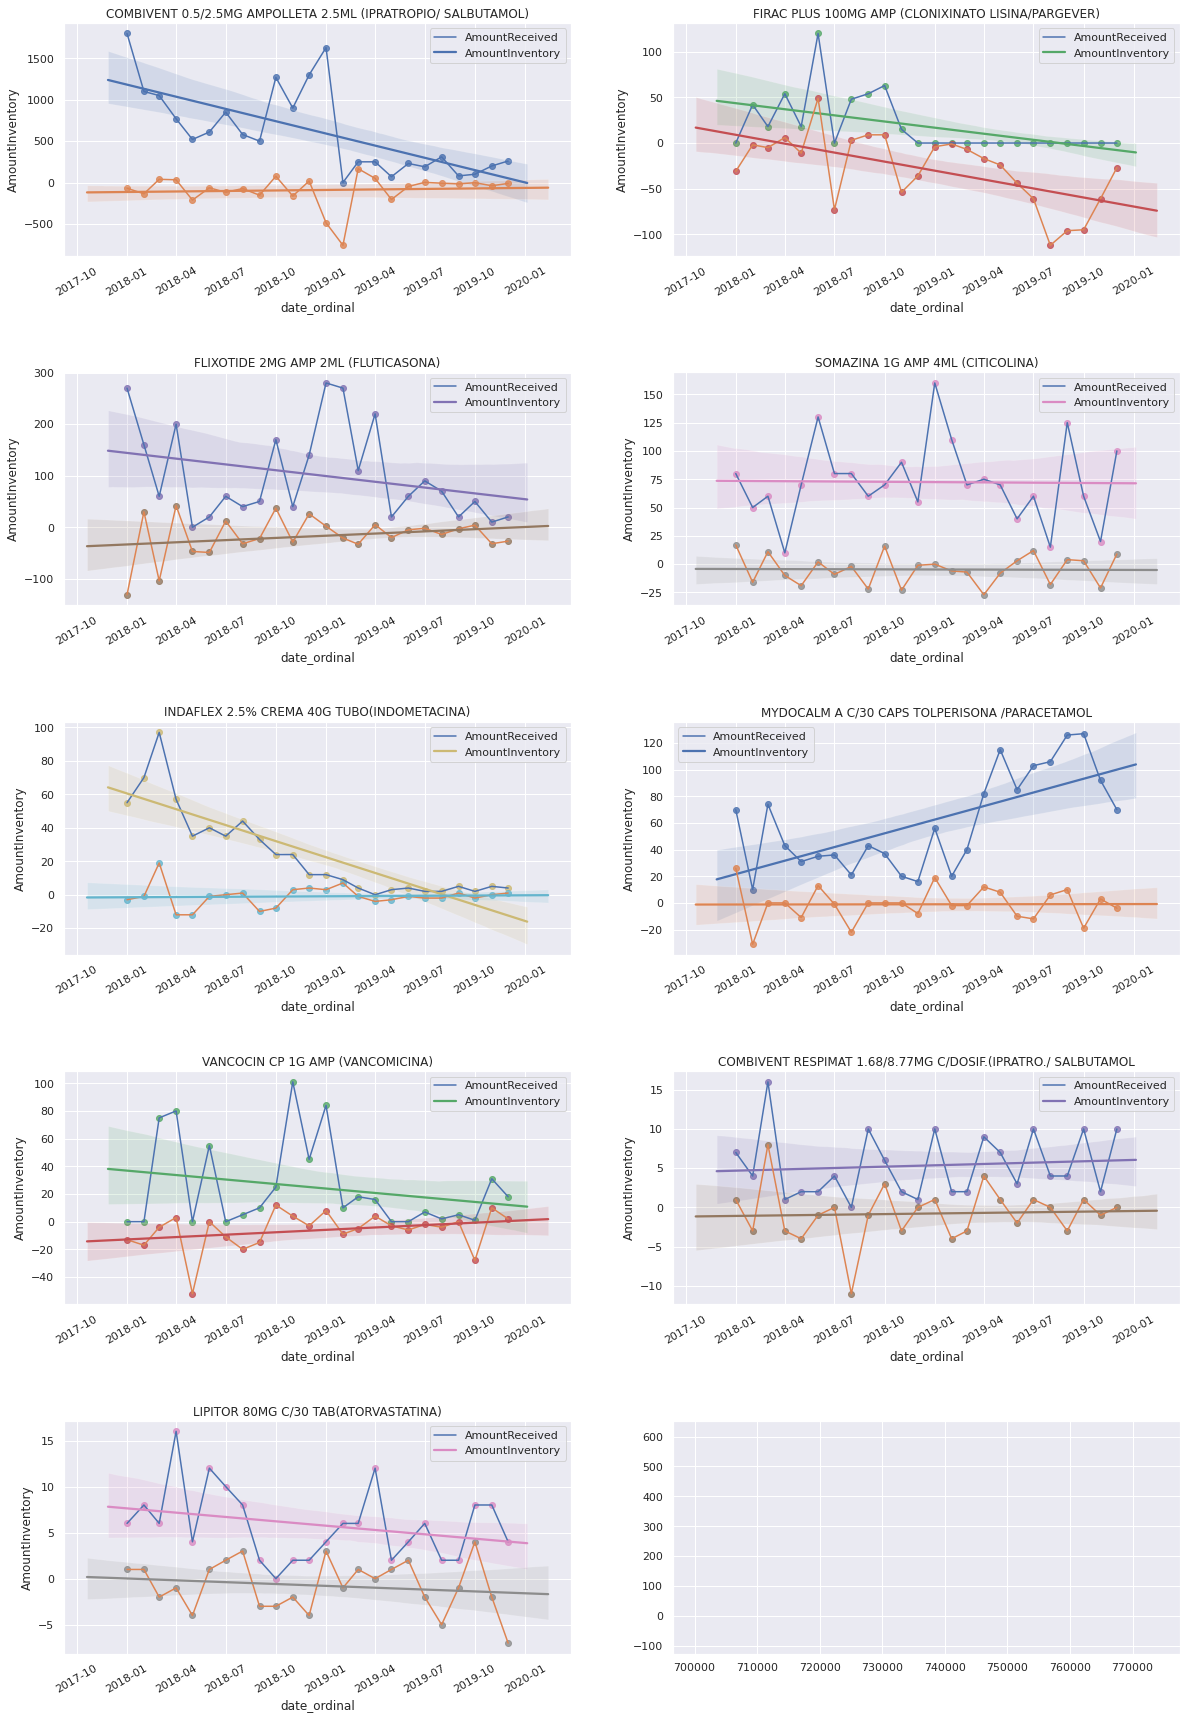

In [73]:
# Plot top compounds inventory

fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)

for ax, MedCode in zip(axes.flatten(), TopS):
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountReceived', ax=ax)
    sns.regplot( data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='date_ordinal', y='AmountReceived', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountInventory', ax=ax)
    sns.regplot( data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='date_ordinal', y='AmountInventory', ax=ax)
    ax.legend(['AmountReceived','AmountInventory'])
    #ax.legend(["AmountRequested","AmountPurchased",'AmountMissing','AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)
    x_reg = np.array(MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode]['date_ordinal']).reshape((-1,1))
    y_reg = np.array(MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode]['AmountInventory'])
    model = LinearRegression().fit(x_reg,y_reg)
    print('Intercept:', model.intercept_ , 'slope:', model.coef_)

plt.savefig('PID CSV/top9 regresion.jpg')

**From the previous linear regressions, we can observe the following:**

1. There are 6 slopes very close to zero, and with little tendency to be over zero, which means that the current methodology for inventory control does not have the capacity to move the inventory from being on shortage.
2. In the case of the 3 negative slopes, for FIRAC PLUS there is not enough data, which makes it not valuable for our analysis. SOMAZINA's slope is valid for our analysis, but it is negative and so small that could be considered ZERO; this demonstrates the lack of capacity to move the inventory stock level from being on shortage. And lastly, LIPITOR, shows a cumbersome behavior because it clearly tells that current methodology does not respond well to changes of demand levels, and on top of this, what makes it even worse is the demand that has a negative slope. 

### PID as an Opportunity
1. PID is designed for a system, in this case an inventory, to stay at a constant level in spite of perturbations, which in our case, is the demand. PID suggests how much volume a purchase should have to keep constant inventory levels. **It is very clear that the inventory suffers from shortages given that its levels are always below zero, and an increase in volume is needed to reach an optimal level.**
2. When there is a perturbation, PID suggest purchases to be done most optimally for the stock inventory level to return as fast as possible to its required level without being affected by overpurchases or shortages. **It is clear that demand is the cause of many perturbations of inventory stock levels, as we can observe in cases like FLIXOTIDE, MIDOCALM, and VANCOCIN, being the most notorious ones.**

### PID Functionalinity
The application of a PID model is done in 2 phases:

1. Simulate the system behavior to calculate the proportion constants of the three elements: Proportional, Integral and Differential. For this simulation, the equations that describe the system are required. These equations are made up of integral and differential elements, and the solution is carried on in the Laplace space.  
2. **Apply the optimized constants in the real system.**

For point 1 above, 2 equations are required:
- The equation of the model one wishes to control (in our case, the drug consumption demand).
- The equation of the PID model.

For point 2, only one equation is required: the equation of the PID model. 

The following Equation 1 shows the integro-differential equation of a PID controller while Equation 2 shows the same equation in the Laplace space.  

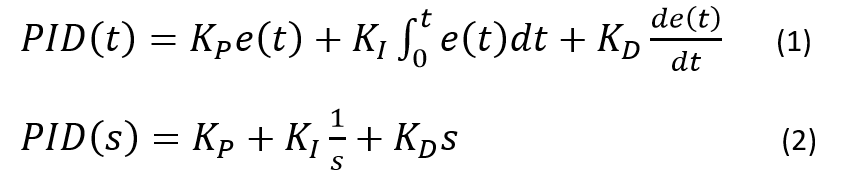

In [74]:
from IPython.display import Image
Image("ecuacion PID.png", width=500)

--------------
The best description of the process that we are interested is Equation 3, where:
- I(t+1) inventory at end of the day.
- I(t) inventory at beginning of the day.
- O(t-T) medicines that arrive today and were requested some time ago T.
- D(t) demand of medicines.


The demand is the most complex part of the simulation process since it can have deterministic and stochastic elements, and this very same demand generates perturbations in the system. If we were to have stable inventory stock levels, a demand event could abruptly change the new level of inventory, and so the PID system should respond with more stable suggestions to avoid losses.

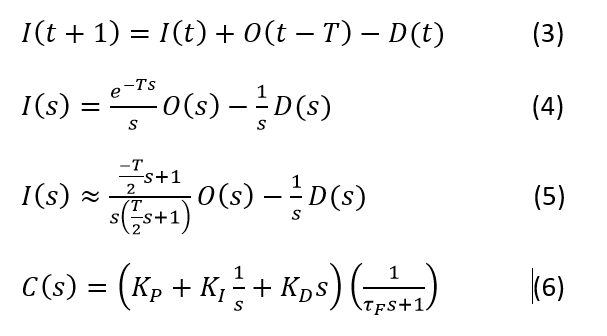

In [75]:
Image("ecuacion proceso.png", width=500)

"differential to algebraic", series expansion to 5, back to space time function

##### -------------------
Curiously, the model shown in Equation 3 is very similar to the model that simulates the integration of a plant with processes that represent delays in the responses of systems. To solve these models, we utilize a first-order Padé approximation, which leads us to equation 4 and 5 in the Laplace space. Finally, we conclude with Equation 6 that integrates the PID model. This equation for C(s) is the PID model with a filter application.    

*** "Inventory Control Loop Diagram" ***

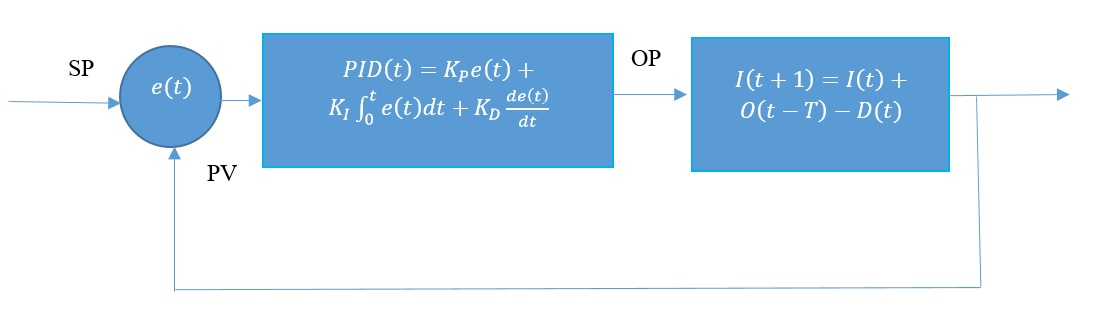

In [100]:
Image("PID lazo cerrado.jpg", width = 500)

-------------
Lastly, the process diagram above shows in which we can appreciate both equations in the Laplace space in a closed loop diagram. On this diagram we can observe how our required inventory level exists as Set Point SP, and the current inventory level is inserted in the PID model for processing, and the suggested volume output will be OP. This variable enters the demand process, and the output is the level of inventory left. This result is compared again with the required inventory level, and repeats the process. After some iterations, we get the desired inventory level. The speed to reach the desired inventory level will be determined by the constants in the PID that are shown in the Laplace space as KP, KI and KD 

### Simulación

For the simulation we use GEKKO which works for us to model the necessary equations. The equations as already said are:

1. The model equation.
2. The PID equation.

In [77]:
## Installing and importing GEKKO 
##!pip install gekko --upgrade
from gekko import GEKKO    

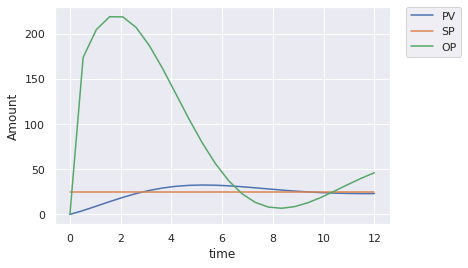

In [78]:
m = GEKKO()
tf = 12
m.time = np.linspace(0,tf,2*tf)      #The time is adjusted to the datetime that we have to the historic data

# Controller model
Kp   = m.FV(value=8.0,lb=0.1, ub=20) # Proportional gain
Kp.STATUS=1                          
Ki   = 10.0                          # Integral gain
Kd   = 12.0                          # Differential gain
#Inicialitation of variables
OP   = m.Var(value=0)
PV   = m.Var(value=0)
SP   = m.Param(value=25)
Integral = m.Var(value=0)
err = m.Intermediate(SP-PV)
m.Equation(Integral.dt()==err)
m.Equation(OP==Kp*err+Ki*Integral-Kd*PV.dt()) #Declaration of PID equation

#Process Model
Kpp   = 0.5
tauP = 10.0
m.Equation(tauP*PV.dt()+PV==Kpp*OP)           #Here is declared a model equation described using a differential
                                              #ecuation that describes the demand
m.options.IMODE = 4
m.solve(disp=False)

plt.figure()
plt.plot(m.time, PV.value, label= 'PV')
plt.plot(m.time, SP.value, label= 'SP')
plt.plot(m.time, OP.value, label= 'OP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("time")
plt.ylabel("Amount")
plt.show()

The obtained graph has 3 important elements for our control. We can see that the OP curve oscillates by large amounts and keeps oscillating over time, this is our modeled demand. While the curve that describes the PV is the level of inventory that we are obtaining. Very quickly we see how PV approaches the desired inventory.

### Implementation on the historical data that we already know.


Now we mount our model on the already known data to adjust the variables and calculate the purchase suggestions for each medicine.

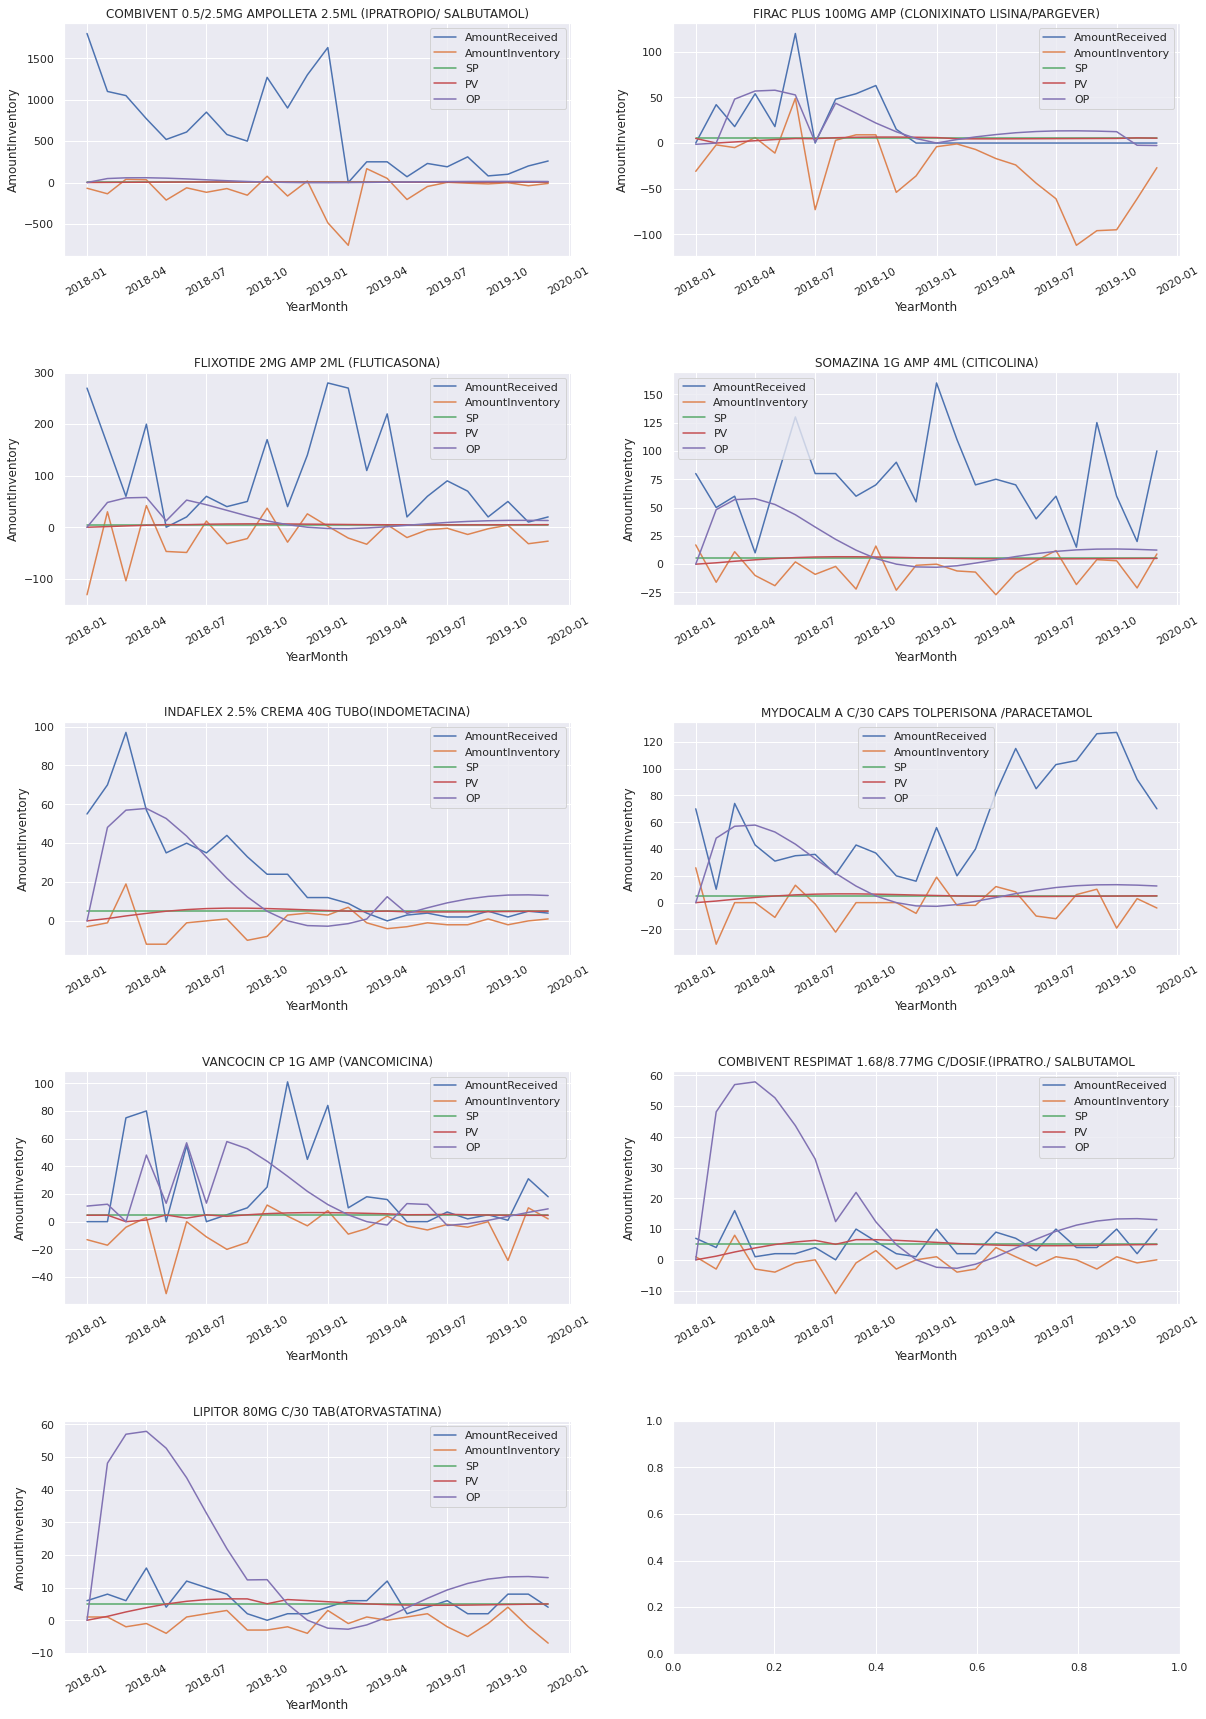

In [79]:
# Plot top compounds inventory
m = GEKKO()
tf = 12
m.time = np.linspace(0,tf,2*tf)
#step = np.zeros(2*tf+1)
#step[3:40] = 2.0
#step[40:]  = 5.0

# Controller model
Kc   = 15.0                    # controller gain
tauI = 0.50                  # controller reset time
tauD = 2.0                  # derivative constant
OP_0 = 0.0
OP   = m.Var(value=0)
PV   = m.Var(value=0)
SP   = m.Param(value=5)
Integral = m.Var(value=0)
err = m.Intermediate(SP-PV)
m.Equation(Integral.dt()==err)
m.Equation(OP==OP_0+Kc*err+(Kc/tauI)*Integral-Kc*tauD*PV.dt())

#Process MOdel
Kp   = 0.5
tauP = 10.0
m.Equation(tauP*PV.dt()+PV==Kp*OP)
m.options.IMODE = 4
m.solve(disp=False)



fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)

for ax, MedCode in zip(axes.flatten(), TopS):
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountReceived', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y='AmountInventory', ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y = SP.value, ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y = PV.value, ax=ax)
    sns.lineplot(data=MonthlyCompounds[MonthlyCompounds["MedDescription"]==MedCode], x='YearMonth', y = OP.value, ax=ax)
 
    ax.legend(['AmountReceived','AmountInventory', 'SP', 'PV', 'OP'])
    #ax.legend(["AmountRequested","AmountPurchased",'AmountMissing','AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)

    

In [101]:
df_combivent = pd.read_csv('PID CSV/top 9 combivent.csv')                         #1
df_firac_plus = pd.read_csv('PID CSV/top 9 firac plus.csv')                       #2
df_flixotide_2mg = pd.read_csv('PID CSV/top 9 flixotide 2mg.csv')                 #3
df_somazina = pd.read_csv('PID CSV/top 9 somazina.csv')                           #4
df_indaflex = pd.read_csv('PID CSV/top 9 indaflex.csv')                           #5
df_mydocalm_C = pd.read_csv('PID CSV/top 9 mydocalm_C.csv')                       #6
df_vancocin_CP = pd.read_csv('PID CSV/top 9 vancocin_CP.csv')                     #7
df_combivent_respimat = pd.read_csv('PID CSV/top 9 combivent_respimat.csv')       #8
df_lipitor = pd.read_csv('PID CSV/top 9 lipitor.csv')                             #9
df_lipitor.head()

,YearMonth,MedCode,RequestNumber,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed,AmountInventory,seccion final,SP,SP M,SP-PV,OP,PV,fecha ordinal,cantidad consumida,promedio,Unnamed: 18
0,01/01/2018,3300142.0,105822.0,6.0,6.0,6.0,0.0,5.0,1.0,NaN,6.09851,9.147765,9.147765,NaN,NaN,NaN,NaN,NaN,NaN
1,01/02/2018,3300142.0,160678.0,8.0,8.0,8.0,0.0,7.0,1.0,NaN,6.09851,9.147765,9.147765,NaN,NaN,NaN,NaN,NaN,NaN
2,01/03/2018,3300142.0,108044.0,5.0,6.0,6.0,-1.0,8.0,-2.0,NaN,6.09851,9.147765,9.147765,NaN,NaN,NaN,NaN,NaN,NaN
3,01/04/2018,3300142.0,382059.0,13.0,17.0,16.0,-3.0,17.0,-1.0,NaN,6.09851,9.147765,9.147765,NaN,NaN,NaN,NaN,NaN,NaN
4,01/05/2018,3300142.0,110571.0,2.0,4.0,4.0,-2.0,8.0,-4.0,NaN,6.09851,9.147765,9.147765,NaN,NaN,NaN,NaN,NaN,NaN


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


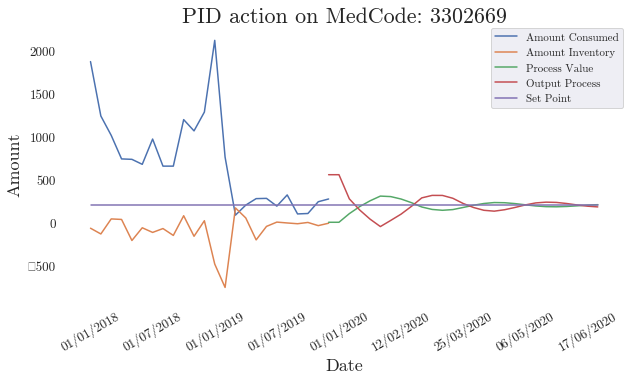

In [99]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

title = 'PID action on MedCode: 3302669'

fig, ax = plt.subplots(figsize=(10, 5))

plt.rc('font', family = 'serif', serif = 'cmr10')
plt.title(title, size=22)
plt.xlabel('Date', size=18)
plt.ylabel('Amount', size=18)
plt.xticks(size=13, rotation=30)
plt.yticks(size=13, rotation=0)
ax.xaxis.set_major_locator(MultipleLocator(6))
ax.set_facecolor((1.0, 1.0, 1.0))
plt.grid(True)

plt.plot(df_combivent['YearMonth'], df_combivent['AmountConsumed'], label= 'Amount Consumed')
plt.plot(df_combivent['YearMonth'], df_combivent['AmountInventory'], label= 'Amount Inventory')
plt.plot(df_combivent['YearMonth'], df_combivent['PV'], label= 'Process Value')
plt.plot(df_combivent['YearMonth'], df_combivent['OP'], label= 'Output Process')
plt.plot(df_combivent['YearMonth'], df_combivent['SP'], label= 'Set Point')
#plt.plot(m.time, OP.value, label= 'OP')
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.)

plt.savefig('plots/'+title, dpi=200, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()


/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


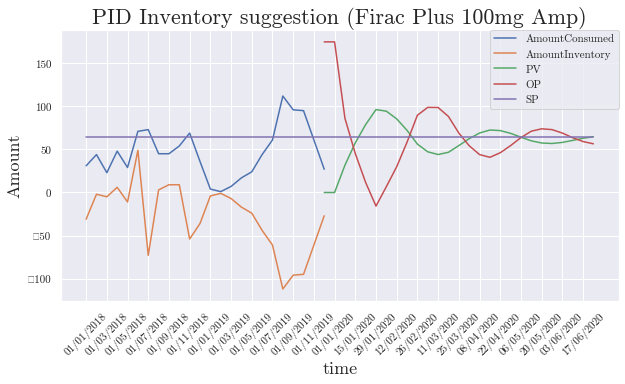

In [102]:
plt.figure(figsize=(10,5))
plt.plot(df_firac_plus['YearMonth'], df_firac_plus['AmountConsumed'], label= 'AmountConsumed')
plt.plot(df_firac_plus['YearMonth'], df_firac_plus['AmountInventory'], label= 'AmountInventory')
plt.plot(df_firac_plus['YearMonth'], df_firac_plus['PV'], label= 'PV')
plt.plot(df_firac_plus['YearMonth'], df_firac_plus['OP'], label= 'OP')
plt.plot(df_firac_plus['YearMonth'], df_firac_plus['SP'], label= 'SP')
#plt.plot(m.time, OP.value, label= 'OP')
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.rc('font', family = 'serif', serif = 'cmr10')
plt.title('PID Inventory suggestion (Firac Plus 100mg Amp)', size=22)
plt.xlabel("time", size=18)
plt.ylabel("Amount", size=18)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 50, 2))
plt.show()

/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


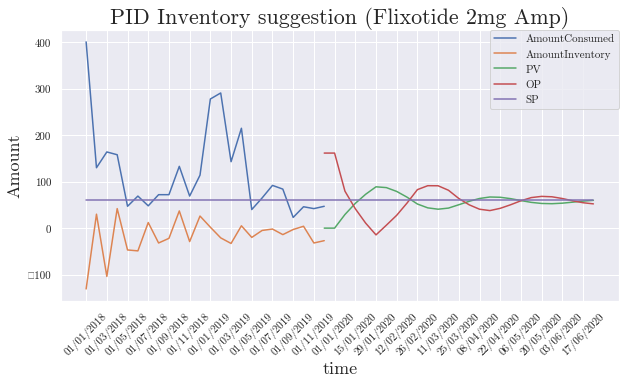

In [103]:
plt.figure(figsize=(10,5))
plt.plot(df_flixotide_2mg['YearMonth'], df_flixotide_2mg['AmountConsumed'], label= 'AmountConsumed')
plt.plot(df_flixotide_2mg['YearMonth'], df_flixotide_2mg['AmountInventory'], label= 'AmountInventory')
plt.plot(df_flixotide_2mg['YearMonth'], df_flixotide_2mg['PV'], label= 'PV')
plt.plot(df_flixotide_2mg['YearMonth'], df_flixotide_2mg['OP'], label= 'OP')
plt.plot(df_flixotide_2mg['YearMonth'], df_flixotide_2mg['SP'], label= 'SP')
#plt.plot(m.time, OP.value, label= 'OP')
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.rc('font', family = 'serif', serif = 'cmr10')
plt.title('PID Inventory suggestion (Flixotide 2mg Amp)', size=22)
plt.xlabel("time", size=18)
plt.ylabel("Amount", size=18)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 50, 2))
plt.show()

___